# High Level Overview of Chicago Bike Sharing Industry

In [1]:
import os
import warnings
import re
from datetime import datetime, date
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, Holt

pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
%matplotlib inline

# Focus Top 20 Station Demand Analysis

# Negative Binomial 

In [2]:
start = time.time()

In [3]:
df_negbin = pd.read_csv("top_20_hourly.csv")
df_negbin.head()

,y_m_d,hour_of_day,tripduration,Demand,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,tempHigh,tempLow,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptHigh,dewptLow,dewptAvg,windchillHigh,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal,Year_Date,Month_Date,Day_Date,season,is_holiday,break_types,day_of_week,is_weekday
0,2019-01-01,0,102.0,1.0,0.0,0.0,156.0,99.0,97.0,97.0,2.0,2.0,2.0,1.0,0,0.0,2.0,0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1014.22,1012.53,1.02,0.0,0.0,2019,1,1,1,1,3,1,1
1,2019-01-01,1,1158.0,1.0,0.0,0.0,147.0,97.0,95.0,96.0,2.0,2.0,2.0,2.0,0,0.0,4.0,0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1015.92,1013.88,1.70,0.0,0.0,2019,1,1,1,1,3,1,1
2,2019-01-01,2,1028.0,3.0,0.0,0.0,134.0,96.0,93.0,94.0,2.0,1.0,2.0,4.0,0,0.0,7.0,0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1017.27,1015.58,1.36,0.0,0.0,2019,1,1,1,1,3,1,1
3,2019-01-01,3,770.0,1.0,0.0,0.0,141.0,97.0,93.0,94.0,1.0,1.0,1.0,3.0,0,0.0,5.0,0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1018.29,1017.27,1.02,0.0,0.0,2019,1,1,1,1,3,1,1
4,2019-01-01,4,362.0,1.0,0.0,0.0,187.0,99.0,96.0,98.0,1.0,0.0,1.0,7.0,0,1.0,9.0,0,1.0,1.0,0.0,0.0,1.0,-2.0,1.0,1.0,0.0,1.0,1019.30,1018.29,1.02,0.0,0.0,2019,1,1,1,1,3,1,1


In [4]:
df_negbin.shape

(8760, 41)

In [5]:
df_negbin["y_m_d"] = pd.to_datetime(df_negbin["y_m_d"])

In [6]:
y = 'Demand'

#Get column names
col_name = list(df_negbin)

#List of column names to be dropped
to_drop = ['tripduration', 'y_m_d','hour_of_day', 'Year_Date', 'Day_Date', 'is_holiday', 
           'humidityHigh','humidityLow','tempHigh','tempLow', 'windspeedHigh',
           'windspeedLow','windgustHigh','windgustLow','dewptHigh', 'dewptLow','windchillHigh',
           'windchillLow','heatindexHigh','heatindexLow', 'pressureMax','pressureMin']

# to_drop = ['y_m_d','hour_of_day', 'Year_Date', 'Day_Date', 'day_of_week', 'is_weekday']

#Dropping column names
for i in range(len(to_drop)):
    col_name.pop(col_name.index(to_drop[i]))

#Move y to position 0 (the start of the column)
col_name.insert(0, col_name.pop(col_name.index(y)))
df_negbin = df_negbin[col_name]

# Move y to front, put Xs more correlated with y in front, drop any X (maybe non-numeric) having no correlation with y
df_negbin = df_negbin[df_negbin[[c for c in col_name if c != y]].corrwith(df_negbin[y]).sort_values(key=abs, ascending = False).dropna().index.insert(0, y)]

#Concatenate the categorical predictors DataFrame at the end of "df_negbin" DataFrame
df_negbin.head(5)

,Demand,uvHigh,solarRadiationHigh,windchillAvg,tempAvg,heatindexAvg,humidityAvg,dewptAvg,season,windgustAvg,Month_Date,windspeedAvg,winddirAvg,precipRate,pressureTrend,precipTotal,break_types,is_weekday,day_of_week
0,1.0,0.0,0.0,2.0,2.0,2.0,97.0,2.0,1,0.0,1,0.0,156.0,0.0,1.02,0.0,3,1,1
1,1.0,0.0,0.0,2.0,2.0,2.0,96.0,1.0,1,0.0,1,0.0,147.0,0.0,1.70,0.0,3,1,1
2,3.0,0.0,0.0,2.0,2.0,2.0,94.0,1.0,1,1.0,1,0.0,134.0,0.0,1.36,0.0,3,1,1
3,1.0,0.0,0.0,1.0,1.0,1.0,94.0,0.0,1,1.0,1,0.0,141.0,0.0,1.02,0.0,3,1,1
4,1.0,0.0,0.0,1.0,1.0,1.0,98.0,0.0,1,1.0,1,1.0,187.0,0.0,1.02,0.0,3,1,1


In [7]:
num_col = df_negbin.shape[1] 
num_col

19

In [8]:
df_negbin["Month_Date"] = df_negbin["Month_Date"].astype(int)
df_negbin["break_types"] = df_negbin["break_types"].astype(int)

In [9]:
df_negbin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Demand              8760 non-null   float64
 1   uvHigh              8760 non-null   float64
 2   solarRadiationHigh  8760 non-null   float64
 3   windchillAvg        8760 non-null   float64
 4   tempAvg             8760 non-null   float64
 5   heatindexAvg        8760 non-null   float64
 6   humidityAvg         8760 non-null   float64
 7   dewptAvg            8760 non-null   float64
 8   season              8760 non-null   int64  
 9   windgustAvg         8760 non-null   float64
 10  Month_Date          8760 non-null   int64  
 11  windspeedAvg        8760 non-null   float64
 12  winddirAvg          8760 non-null   float64
 13  precipRate          8760 non-null   float64
 14  pressureTrend       8760 non-null   float64
 15  precipTotal         8760 non-null   float64
 16  break_

In [10]:
#This function is to address collinearity issue

def delcorr(df):
    corv = df.iloc[:, 1:].corrwith(df[y]).rename(y).sort_values(key=abs).to_frame()
    
    # corr difference lower limit
    delta = 0.01
    dl2 = []
    icorr = True
    while icorr:
        a = abs(corv).diff() <= delta
        col_name=list(df)[1:]
        dl=[]
        print('\nX pairs with correlations >', 1 - delta, ':')
        for b in range(1, a.shape[0]):
            if a.iloc[b, 0]:
                if abs(df[a.index[b-1]].corr(df[a.index[b]])) > 1 - delta:
                    #deleting 1 X from correlated pair:
                    dv0 = a.index[b - 1]
                    dv1 = a.index[b]
                    
                    #neither should already be deleted:
                    if not (dv0 in dl) and not (dv1 in dl):
                        #delete x with rather lower corr(x, y):
                        if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                            d = dv1
                        elif len(dv0) < len(dv1):
                            d = dv1
                        else:
                            d = dv0
                        #for en masse deletion later    
                        dl.append(d)
                        #delete from column of corr with y
                        corv.drop([d], axis=0, inplace=True)
                        print(dv0, ',', dv1)
        
        if len(dl) > 0:
            #variables deleted en masse
            df.drop(axis=1, columns=dl, inplace=True)
            #Keep for real deletion later
            dl2 = dl2 + dl
            print('\n' + str(len(dl)), 'variables considered for deletion:')
            print('\n'.join([str(x) for x in dl]))
        else:
            print('(no more)')
            icorr = False
    print('\n' + str(len(dl2)), 'collinear variables deleted.')
    return dl2

In [11]:
#Create a copy of df_negbin and store it in a variable named df_negbin_copy
df_negbin_copy = df_negbin.copy()
print(df_negbin)
print(df_negbin.dtypes)
#find collinearity deletion candidates among original variables.
dl2 = delcorr(df_negbin)

print(dl2)

if len(dl2) > 0:
    #collinear transformed variables deleted en masse, for real
    df_negbin_copy.drop(axis=1, columns=dl2, inplace=True)
    #remaining Xs may still have multi-X collinearity
    print('\n' + str(len(dl2)), 'variables deleted.')
    
#only numeric columns left

#move transformations more correlated with Y to front:
df_negbin_copy = pd.concat([df_negbin_copy[list(df_negbin_copy)[:num_col]], df_negbin_copy[df_negbin_copy[[c for c in list(df_negbin_copy)[num_col:] if c != y]].corrwith(df_negbin_copy[y]
                    ).sort_values(key=abs, ascending=False).index]], 1)

#keep df_negbin_copy for inclusion of interaction variables later
df_negbin = df_negbin_copy.copy() 

df_negbin_copy.head(5)

      Demand  uvHigh  solarRadiationHigh  windchillAvg  tempAvg  heatindexAvg  \
0        1.0     0.0                 0.0           2.0      2.0           2.0   
1        1.0     0.0                 0.0           2.0      2.0           2.0   
2        3.0     0.0                 0.0           2.0      2.0           2.0   
3        1.0     0.0                 0.0           1.0      1.0           1.0   
4        1.0     0.0                 0.0           1.0      1.0           1.0   
...      ...     ...                 ...           ...      ...           ...   
8755     7.0     0.0                 0.0           2.0      2.0           2.0   
8756     5.0     0.0                 0.0           2.5      2.5           2.5   
8757     3.0     0.0                 0.0           2.5      2.5           2.5   
8758     1.0     0.0                 0.0           2.0      2.0           2.0   
8759    13.0     0.0                 0.0           2.0      2.0           2.0   

      humidityAvg  dewptAvg

,Demand,uvHigh,solarRadiationHigh,tempAvg,humidityAvg,dewptAvg,season,windgustAvg,Month_Date,windspeedAvg,winddirAvg,precipRate,pressureTrend,precipTotal,break_types,is_weekday,day_of_week
0,1.0,0.0,0.0,2.0,97.0,2.0,1,0.0,1,0.0,156.0,0.0,1.02,0.0,3,1,1
1,1.0,0.0,0.0,2.0,96.0,1.0,1,0.0,1,0.0,147.0,0.0,1.70,0.0,3,1,1
2,3.0,0.0,0.0,2.0,94.0,1.0,1,1.0,1,0.0,134.0,0.0,1.36,0.0,3,1,1
3,1.0,0.0,0.0,1.0,94.0,0.0,1,1.0,1,0.0,141.0,0.0,1.02,0.0,3,1,1
4,1.0,0.0,0.0,1.0,98.0,0.0,1,1.0,1,1.0,187.0,0.0,1.02,0.0,3,1,1


In [12]:
import statsmodels.api as sm
import regex as re

#model equation:
eq = 'Demand ~ uvHigh + solarRadiationHigh + tempAvg + humidityAvg + dewptAvg + windgustAvg + winddirAvg + precipRate + windspeedAvg + precipTotal + tripduration + pressureTrend'

# XXX is regarded as categorical variables from here onwards.

### 2. Converting season to categorical variable...

print("\n\nUnique values in numerical variable 'season':", sorted(set(df_negbin['season'].dropna()))
      + ([np.nan] if df_negbin['season'].isnull().sum() > 0 else []))

#turn numerical variable season into categorical dummies
#use short prefix 'd1' instead of the obvious 'season' for better printing output
d1 = pd.get_dummies(df_negbin['season'], prefix='season', drop_first=True)
#any variable name character which is 'not alphanumeric or' '_' will be replaced by '_':
d1.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)

print("\nCategorical dummies from numerical variable 'season':\n")
print(d1.head())

### 3. Converting Month_Date to categorical variable...

print("\n\nUnique values in numerical variable 'month_date':", sorted(set(df_negbin['Month_Date'].dropna()))
      + ([np.nan] if df_negbin['Month_Date'].isnull().sum() > 0 else []))

#turn numerical variable weathersit into categorical dummies
#use short prefix 'd2' instead of the obvious 'weathersit' for better printing output
d2 = pd.get_dummies(df_negbin['Month_Date'], prefix='month_date', drop_first=True)
#any variable name character which is 'not alphanumeric or' '_' will be replaced by '_':
d2.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)

print("\nCategorical dummies from numerical variable 'month_date':\n")
print(d2.head())

### 4. Converting break_types to categorical variable...

print("\n\nUnique values in numerical variable 'break_types':", sorted(set(df_negbin['break_types'].dropna()))
      + ([np.nan] if df_negbin['break_types'].isnull().sum() > 0 else []))

#turn numerical variable holiday into categorical dummies
#use short prefix 'd3' instead of the obvious 'holiday' for better printing output
d3 = pd.get_dummies(df_negbin['break_types'], prefix='break_types', drop_first=True)
#any variable name character which is 'not alphanumeric or' '_' will be replaced by '_':
d3.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)

print("\nCategorical dummies from numerical variable 'break_types':\n")
print(d3.head())

d = pd.concat([df_negbin.drop(['season'], axis=1), d1], axis=1)
d = pd.concat([d.drop(['Month_Date'], axis=1), d2], axis=1)
d = pd.concat([d.drop(['break_types'], axis=1), d3], axis=1)

print('\n\nReconstituted dataset has', len(d), 'rows.\n')
print(d.head())

#Test print model equation:
print('\n Old model equation: ' + eq + '\n')

#List out all d0 dummies
print(list(d1))
print(list(d2))
print(list(d3))

# #Append the columns in d1 to model equation:
eq = eq + ' + ' + ' + '.join(list(d1)) + ' + ' + ' + '.join(list(d2))
print('\n New model equation: ' + eq + '\n')
print(sm.GLM(d[y], sm.add_constant(d.drop(y, axis=1)), family=sm.families.NegativeBinomial()).fit().summary2())



Unique values in numerical variable 'season': [1, 2, 3, 4]

Categorical dummies from numerical variable 'season':

   season_2  season_3  season_4
0         0         0         0
1         0         0         0
2         0         0         0
3         0         0         0
4         0         0         0


Unique values in numerical variable 'month_date': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Categorical dummies from numerical variable 'month_date':

   month_date_2  month_date_3  month_date_4  month_date_5  month_date_6  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   month_date_7  month_date_8  month_date_9  month_date_10  month_date_11  \
0          

In [13]:
dt = d
yname = 'Demand'

delrow = False #delete any row with any missing; else delete any column with any missing
#no matter delrow, always retain only numeric columns & delete rows with missing y:
if delrow:
    dt = dt.select_dtypes(include='number').replace([float('inf'), float('-inf')], float('nan')).dropna(
        0, subset=[yname]).dropna()[dt.columns[dt.nunique() > 1]]
else:
    #delete any column with any missing:
    dt = dt.select_dtypes(include='number').replace([float('inf'), float('-inf')], float('nan')).dropna(
        0, subset=[yname]).dropna(1)
    
#non-numeric columns could also be removed later while trying to create transformations
dt = dt[dt.columns[dt.nunique() > 1]] #delete any column of same value
    
dt.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True) #replace ' ' by '_' in variable names
yname = re.sub('\W', '_', yname)

#move y to front:
if yname != dt.columns[0]:
    dt = dt[[yname] + list(dt.columns.drop(yname))]

m = 'NegativeBinomial'
dist = sm.families.NegativeBinomial()

In [14]:
df_negbin = sm.add_constant(dt.iloc[:, 1:])
y = dt.iloc[:, 0]

#Do variable transformation. Transform all Xs into either square & square-root or cube & cube-root

print('\nCreating transformed Xs ...')

trf = ['_sqar', '_sqrt', '_cube', '_cbrt']

for i in list(df_negbin)[1:]:
    #excluded either y, column with only 1 or 2 distinct values, or transformed variable:
    if df_negbin[i].nunique() > 2 and i[-5:] not in trf:
        failed = False
        try:
            #searching for -ve values:
            df_negbin[i + trf[1]] = np.sqrt(df_negbin[i])
            if df_negbin[i + trf[1]].isnull().any():

                failed = True
                del df_negbin[i + trf[1]]
            else:    
                df_negbin[i + trf[0]] = df_negbin[i] ** 2.
        except:
            failed = True
        if failed:
            try:
                #searching for non-numeric
                df_negbin[i + trf[2]] = df_negbin[i] ** 3.
                df_negbin[i + trf[3]] = np.cbrt(df_negbin[i])
            except:
                #column cannot be transformed
                #delete non-numeric column (with no questions asked!):
                df_negbin.drop(i, axis=1, inplace=True) #remove any row with any NaN

#only numeric columns left


Creating transformed Xs ...


In [15]:
# train-test split setting (seed) for reproducibility
from sklearn.model_selection import train_test_split
seed = 1
 
#split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(df_negbin, y, test_size=.2, random_state=seed) 

#sort columns by absolute correlation with y, so may preferably delete last column if regression fails:
x_train = x_train[x_train.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]

print('\nFit using reproducible random 80% (x_train & y_train) of data rows:')

#first do OLS on untransformed Xs:
df_negbin = pd.concat([y_train, x_train.iloc[:, 1:]], axis=1)
xpure = [x for x in list(df_negbin) if x[-5:] not in trf]
numx = len(xpure) - 1
print('\nOLS fit including only', numx, 'untransformed Xs:')

#initialize for adj-R2:
ddf = np.inf #deficiency in degree of freedom = rank deficiency
maxR2 = -np.inf
bmodeleq = ''

modeleq = ' + '.join(list(xpure)).replace('+', '~', 1)

try:
    out = ols(modeleq, df_negbin).fit()
    print(out.summary2())
    if numx > 1:
        print("\nDescending order of", numx, "X's significance, assuming Normal error distribution:")
        print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
        #if the single best variable isn't high in above ranking, collinearity might be an issue
        modeleq = yname + ' ~ ' + ' + '.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)) #order of x's effect

    dfm = int(out.df_model)

    ddf = numx - dfm #rank deficiency
    maxR2 = out.rsquared_adj
    bmodeleq = modeleq
    print('\n' + 'Rank deficiency =', str(ddf) + ': Df Model (' + str(dfm) + ') is',
          ('less than' if ddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
except:
    pass

print('\nFitting with', df_negbin.shape[1] - 1, '(including transformed) Xs:')

x_test0 = x_test.copy()
prmse = ''
df_negbin = x_train
y = y_train
    
print('\n\nAssuming', m, 'error distribution...')

#undo above ols:
ddf = np.inf
maxR2 = -np.inf
bmodeleq = ''

bic0 = np.inf #bic kept by lowest overall rank deficiency
bic5 = bic0   #bic kept by best model with p-values < 0.05
bicd = bic0   #bic kept by lowest rank deficiency
bbic = bic0   #best bic kept by adj-R2

p05 = False #once found all Xs' p-values < 0.05

#initialize for rank deficiency:
ddfd = ddf #best rank deficiency
R2df = maxR2 #R2 for best rank deficiency
modeleqdf = bmodeleq #modeleq for best rank deficiency

#initialize for overall rank deficiency
ddf0 = ddfd
R2df0 = R2df
modeleqdf0 = modeleqdf

bddf = ddfd #rank deficiency for best adj-R2 model

#initialize for z-stat p-values < 0.05:
ddf5 = np.inf #rank deficiency for best model with p-values < 0.05
R205 = -np.inf #adj-R2 for best model with p-values < 0.05
modeleq05 = '' #modeleq for best model with p-values < 0.05

df0 = df_negbin.copy() #kept for inclusion of interaction variables later

#Perform feature selection using adjusted R2

#model equation actually not used by GLM:
modeleq = ' + '.join(list(df_negbin)).replace('+', '~', 1)
#print(modeleq)
numx = df_negbin.shape[1] - 1

x1x2 = False #interaction variables not yet included

while True:
        #GLM distribution
    try:
        out = sm.GLM(y, df_negbin, family=dist).fit()
        R2 = 1 - (1 - y.corr(out.fittedvalues)**2) * (out.nobs - 1) / out.df_resid #pseudo adjusted r2
        if R2 != R2 and out.fittedvalues.isna().sum() == 0:
            R2 = -np.inf

    except:
        #GLM failed!  do ols for this round, just to delete 1 x:
        try:
            out = ols(' + '.join(list(df_negbin)).replace('+', '~', 1), df_negbin).fit() #do OLS instead
        except:
            pass
        R2 = -np.inf

    try:
        maxp = max(out.pvalues[1:])
        dfm = int(out.df_model)
    except:
        maxp = 1
        dfm = 0
    ddf = numx - dfm #rank deficiency

    #see if a better model is found:
    try:
#             if R2 >= maxR2 and out.fittedvalues.isna().sum() == 0:
        if R2 >= maxR2 and out.fittedvalues.isna().sum() == 0 and ddf <= bddf:
            maxR2 = R2
            bmodeleq = modeleq
#                 bddf = min(bddf, ddf)
            bddf = ddf

            ddf0 = ddf #best overall rank deficiency

            if maxR2 == -np.inf:
                bbic = out.bic

            if maxp >= 0.05 and not p05:
                #reset z-stat p-value criterion:
                R205 = -np.inf
                modeleq05 = ''

                #reset rank deficiency criterion:
                R2df = R205
                modeleqdf = ''
                ddfd = bddf #reset deficient df
            else:
                p05 = True

        #see if a model is found with reduced overall rank deficiency:
        if ddf < ddf0 or (ddf == ddf0 and R2 > R2df0):
            R2df0 = R2
            modeleqdf0 = modeleq
            ddf0 = ddf #best overall rank deficiency
            if maxR2 == -np.inf:
                bic0 = out.bic

        #see if a better model is found with max(z-stat p-value) < .05:
        if maxp < .05 and (R2 > R205 or modeleq05 == ''):
            R205 = R2
            modeleq05 = modeleq
            ddf5 = min(ddf5, ddf) #rank deficiency for best model with p-values < .05
            if maxR2 == -np.inf:
                bic5 = out.bic

        #see if a model is found with reduced rank-deficiency:
        if ddf < ddfd or (ddf == ddfd and R2 > R2df):
            R2df = R2
            modeleqdf = modeleq
            ddfd = min(ddfd, ddf) #best rank deficiency
            if maxR2 == -np.inf:
                bicd = out.bic
    except:
        pass

    print('\nAdjusted R² =', R2, ', max(X p-value) =', maxp, ', rank deficiency =', ddf, ', for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break

        else:
            if maxR2 == -np.inf and out.fittedvalues.isna().sum() > 0:
                print("\n*** Y variable '" + (y.name) + "' might not work with", m, 'distribution.')
                #use all Xs before deletion:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            else:
                #see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
                if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
                    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
                    bmodeleq = modeleq05
                    maxR2 = R205
                    bddf = ddf5

                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bic5 #best bic
                        bic5 = np.inf #re-initialize

                #see if model with smallest rank-deficiency is smaller than best model so far:
                if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
                    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
                    bmodeleq = modeleqdf
                    maxR2 = R2df
                    bddf = ddfd

                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bicd #best bic
                        bicd = np.inf #re-initialize

                if maxR2 == -np.inf:
                    #reset z-stat p-value criterion:
                    R205 = -np.inf
                    modeleq05 = ''

                    #reset rank deficiency criterion:
                    R2df = R205
                    modeleqdf = ''
                    ddfd = np.inf #reset deficient df

            #Add interaction variables for original untransformed variables in best model so far

            numx = bmodeleq.count('+') + bmodeleq.count('~')
            if numx == 0:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                numx = bmodeleq.count('+') + bmodeleq.count('~')
            print('\nRestarting from best model (with', numx, 'Xs & Adjusted R² =', str(maxR2) + ') found so far...')

            colname = bmodeleq.replace('~', '+').split(' + ')
            df_negbin = df0[colname]
            colname = colname[1:] #remove y or 'const'
            x_test = x_test[colname]

            xpure = [x for x in colname if x[-5:] not in trf] #untransformed x names
            #Add any root name of transformed x name:
            xpure = list(set(xpure + [x[:-5] for x in colname if x[-5:] in trf and x[:-5] in list(df0)]))
            xpure = [x for x in colname if x in xpure] + [x[:-5] for x in colname if x[:-5] in xpure] #restore preferred order
            i = len(xpure) - 1

            #actually, nothing to do if i<=0
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  '(untransformed) variable-roots in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = xpure[j] + '_x_' + xpure[k]
                    df_negbin[a] = df0[xpure[j]] * df0[xpure[k]]
                    if df_negbin[a].nunique() < 2:
                        #delete column of constant
                        df_negbin.drop(a, 1, inplace=True)
                    else:
                        print(a)
                        x_test[a] = x_test0[xpure[j]] * x_test0[xpure[k]]

            df0 = df_negbin.copy()
            
            print(df_negbin)

            #Sort columns by absolute correlation with y, so may delete last column if regression fails:
            df0 = df0[[df0.columns[0]] + list(df0.iloc[:, 1:].corrwith(y_train)
                                              .sort_values(ascending=False, na_position='first', key=abs).index)]

            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            if maxR2 == -np.inf:
                bddf = np.inf
                ddf5 = bddf
                ddfd = bddf
                p05 = False
            x1x2 = True #interaction variables already included

            #Beyond-pairwise collinearity may still be introduced with the interaction variables

            df_negbin = df0.copy() #ready for continuing deletion
            continue

    #Identify X variable to delete by finding the one with smallest abs(t-stat):
    t = out.tvalues[1:]
    try:
        xdrop = list(t[abs(t) == min(abs(t))].index)[-1]
    except:
        xdrop = list(t.index)[-1]
    print('Variable to drop:', xdrop)

    df_negbin.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df_negbin)).replace('+', '~', 1)

    numx = numx - 1

#See if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
    bmodeleq = modeleq05
    maxR2 = R205
    bddf = ddf5

#See if model with smallest rank-deficiency is smaller than best model so far:
if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
    bmodeleq = modeleqdf
    maxR2 = R2df
    bddf = ddfd

if maxR2 == -np.inf and out.fittedvalues.isna().any():
    #some nan in y fit
    print("\n*** Y variable '" + (y.name) + "' might not work with", m, 'distribution.')
else:
    try:
        if bddf >= ddf0 and ((maxR2 > -np.inf and R2df0 >= maxR2) or (maxR2 == -np.inf and bic0 <= bbic)):
            bmodeleq_0 = bmodeleq
            maxR2_0 = maxR2
            bddf_0 = bddf

            out = sm.GLM(y, df0[modeleqdf0.replace('~', '+').split(' + ')], family=dist).fit()
            if max(out.pvalues[1:]) < 0.05:
                #Xs' p-values < 0.05
                bmodeleq = modeleqdf0
                maxR2 = R2df0
                bddf = ddf0
    except:
        bmodeleq = bmodeleq_0
        maxR2 = maxR2_0
        bddf = bddf_0

    try:
        df0 = df0[bmodeleq.replace('~', '+').split(' + ')]
        out = sm.GLM(y, df0, family=dist).fit()
        x_test = sm.add_constant(x_test)[df0.columns]

        numx = bmodeleq.count('+') + bmodeleq.count('~')
        print('\nBest model has', numx, 'Xs (Adjusted R² =', str(maxR2), ', rank deficiency =', str(bddf) + '):\n')
        print(out.summary2())

        if numx > 1:
            print("Descending order of", numx, "X's significance, assuming", m, 'error distribution:')
            cfzv = pd.concat([pd.concat([out.params[:1], out.tvalues[:1]], 1), pd.concat([out.params[1:], out.tvalues[1:]], 1
                   ).sort_values(1, key=abs, ascending=False)])
            #print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
            print(cfzv.rename(columns={0:"Coefficient", 1:"z-stat"}))
            #if the single best variable isn't high in above ranking, collinearity might be an issue
            bmodeleq = bmodeleq[:bmodeleq.find('~') + 2] + ' + '.join(cfzv.index[1:]) #in order of x importance

        dfm = int(out.df_model)
        print('\n' + 'Rank deficiency =', str(bddf) + ': Df Model (' + str(dfm) + ') is',
              ('less than' if bddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')

    except:
        print("\n*** Y variable '" + (y.name) + "' might not work with", m, 'distribution.')


Fit using reproducible random 80% (x_train & y_train) of data rows:

OLS fit including only 30 untransformed Xs:

Fitting with 54 (including transformed) Xs:


Assuming NegativeBinomial error distribution...

Adjusted R² = 0.49901544873428894 , max(X p-value) = 0.9189706957523223 , rank deficiency = 0 , for 54 Xs.
Variable to drop: windgustAvg_sqar

Adjusted R² = 0.49901974404390936 , max(X p-value) = 0.7136074891148423 , rank deficiency = 0 , for 53 Xs.
Variable to drop: precipRate_sqar

Adjusted R² = 0.499151629448486 , max(X p-value) = 0.6896185254155779 , rank deficiency = 0 , for 52 Xs.
Variable to drop: windgustAvg

Adjusted R² = 0.49922636307348023 , max(X p-value) = 0.6741512704318291 , rank deficiency = 0 , for 51 Xs.
Variable to drop: pressureTrend_cbrt

Adjusted R² = 0.4987159664863331 , max(X p-value) = 0.659972644573469 , rank deficiency = 0 , for 50 Xs.
Variable to drop: season_3

Adjusted R² = 0.49876250984518533 , max(X p-value) = 0.6147414580256181 , rank deficiency =

month_date_6_x_solarRadiationHigh
month_date_6_x_solarRadiationHigh
month_date_6_x_windgustAvg
month_date_5_x_solarRadiationHigh
month_date_5_x_solarRadiationHigh
month_date_5_x_windgustAvg
month_date_4_x_solarRadiationHigh
month_date_4_x_solarRadiationHigh
month_date_4_x_windgustAvg
month_date_10_x_solarRadiationHigh
month_date_10_x_solarRadiationHigh
month_date_10_x_windgustAvg
solarRadiationHigh_x_solarRadiationHigh
solarRadiationHigh_x_windgustAvg
solarRadiationHigh_x_windgustAvg
      const  solarRadiationHigh_sqrt  solarRadiationHigh  \
54      1.0                 0.000000                0.00   
5748    1.0                23.494042              551.97   
8382    1.0                 0.000000                0.00   
4228    1.0                 0.000000                0.00   
7437    1.0                 0.000000                0.00   
...     ...                      ...                 ...   
2895    1.0                12.587692              158.45   
7813    1.0                 5.0


Adjusted R² = 0.5080025184192158 , max(X p-value) = 0.9746521307134108 , rank deficiency = 9 , for 45 Xs.
Variable to drop: month_date_5_x_windgustAvg

Adjusted R² = 0.5080893298389071 , max(X p-value) = 0.9438360216040644 , rank deficiency = 9 , for 44 Xs.
Variable to drop: month_date_7_x_solarRadiationHigh

Adjusted R² = 0.5080893262498758 , max(X p-value) = 0.9438348972826315 , rank deficiency = 8 , for 43 Xs.
Variable to drop: solarRadiationHigh_x_month_date_7

Adjusted R² = 0.5081936372412101 , max(X p-value) = 0.7728360150085494 , rank deficiency = 8 , for 42 Xs.
Variable to drop: solarRadiationHigh_x_month_date_5

Adjusted R² = 0.5081936942616292 , max(X p-value) = 0.77284137068451 , rank deficiency = 7 , for 41 Xs.
Variable to drop: month_date_5_x_solarRadiationHigh

Adjusted R² = 0.5080957144815177 , max(X p-value) = 0.7117400128892939 , rank deficiency = 7 , for 40 Xs.
Variable to drop: solarRadiationHigh_x_windgustAvg

Adjusted R² = 0.5080818138506811 , max(X p-value) = 0.6

# Triple Exponential Method (Winters-Holt)

In [16]:
df_winter1 = pd.read_csv("top_20_daily.csv")

In [17]:
df_winter1["y_m_d"] = pd.to_datetime(df_winter1["y_m_d"])

In [18]:
yn = 'Demand'

print('\nThe dataset has', len(df_winter1), 'rows and', df_winter1.shape[1], 'columns.')

# data cleaning
cn = list(df_winter1)
print('\nColumns are:', cn)

cn.insert(0, cn.pop(cn.index(yn)))
df_winter1 = df_winter1[cn]

df_winter1.drop(columns=['tripduration', 'humidityHigh','humidityLow','tempHigh','tempLow','windspeedHigh','windspeedLow','windgustHigh',
                 'windgustLow','dewptHigh','dewptLow','windchillHigh','windchillLow','heatindexHigh',
                 'heatindexLow','pressureMax','pressureMin', 'Month_Date', 'is_holiday', 'Day_Date'], inplace=True)

df_winter1.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)
yn = re.sub('\W', '_', yn)

df_winter1.head()



The dataset has 365 rows and 40 columns.

Columns are: ['y_m_d', 'tripduration', 'solarRadiationHigh', 'uvHigh', 'winddirAvg', 'humidityHigh', 'humidityLow', 'humidityAvg', 'tempHigh', 'tempLow', 'tempAvg', 'windspeedHigh', 'windspeedLow', 'windspeedAvg', 'windgustHigh', 'windgustLow', 'windgustAvg', 'dewptHigh', 'dewptLow', 'dewptAvg', 'windchillHigh', 'windchillLow', 'windchillAvg', 'heatindexHigh', 'heatindexLow', 'heatindexAvg', 'pressureMax', 'pressureMin', 'pressureTrend', 'precipRate', 'precipTotal', 'Year_Date', 'Month_Date', 'Day_Date', 'is_holiday', 'break_types', 'Demand', 'season', 'day_of_week', 'is_weekday']


,Demand,y_m_d,solarRadiationHigh,uvHigh,winddirAvg,humidityAvg,tempAvg,windspeedAvg,windgustAvg,dewptAvg,windchillAvg,heatindexAvg,pressureTrend,precipRate,precipTotal,Year_Date,break_types,season,day_of_week,is_weekday
0,20.0,2019-01-01,30.15,1.0,177.249238,92.324695,-0.905488,0.221799,0.767530,-1.962652,-0.905488,-0.905488,0.274695,0.00000,0.00,2019.0,3.0,1,1,1
1,189.0,2019-01-02,52.57,1.0,192.577698,84.605516,-9.694245,0.000000,0.000000,-11.855156,-9.694245,-9.694245,0.039302,0.00000,0.00,2019.0,0.0,1,2,1
2,236.0,2019-01-03,139.06,3.0,253.507654,81.682271,-1.341403,0.308473,0.995194,-3.901566,-1.341403,-1.341403,-0.015335,0.00000,0.00,2019.0,0.0,1,3,1
3,670.0,2019-01-04,425.43,7.0,179.654219,58.301749,6.465826,0.000000,0.000000,-1.139135,6.465826,6.465826,-0.398155,0.00000,0.00,2019.0,0.0,1,4,1
4,727.0,2019-01-05,270.56,5.0,130.619437,91.531830,12.215592,0.033726,0.100778,11.135036,12.215592,12.215592,0.538531,0.14019,300607.55,2019.0,2.0,1,5,0


In [19]:
df_winter1["break_types"].value_counts()

0.0    197
2.0     82
1.0     78
3.0      8
Name: break_types, dtype: int64

In [20]:
df_winter1["break_types"] = pd.Categorical(df_winter1["break_types"])
break_types_dummies = pd.get_dummies(df_winter1["break_types"], drop_first=True, prefix="break_types")
df_winter1 = pd.concat([df_winter1, break_types_dummies], axis=1)
df_winter1.drop(columns=["break_types"], inplace=True)
df_winter1 = df_winter1.rename(columns={'break_types_1.0': 'break_types_one', 'break_types_2.0': 'break_types_two', 'break_types_3.0': 'break_types_three',})

In [21]:
# df_winter1["season"] = pd.Categorical(df_winter1["season"])
# season_dummies = pd.get_dummies(df_winter1["season"], drop_first=True, prefix="season")
# df_winter1 = pd.concat([df_winter1, season_dummies], axis=1)
# df_winter1.drop(columns=["season"], inplace=True)
# df_winter1 = df_winter1.rename(columns={'season_1': 'season_one', 'season_2': 'season_two', 'season_3': 'season_three', 'season_4': 'season_four'})

In [22]:
# df_winter1["day_of_week"] = pd.Categorical(df_winter1["day_of_week"])
# day_of_week_dummies = pd.get_dummies(df_winter1["day_of_week"], drop_first=True, prefix="day_of_week")
# df_winter1 = pd.concat([df_winter1, day_of_week_dummies], axis=1)a
# df_winter1.drop(columns=["day_of_week"], inplace=True)
# df_winter1 = df_winter1.rename(columns={'day_of_week_0': 'day_of_week_zero', 'day_of_week_1': 'day_of_week_one', 'day_of_week_2': 'day_of_week_two', 'day_of_week_3': 'day_of_week_three', 'day_of_week_4': 'day_of_week_four', 'day_of_week_5': 'day_of_week_five', 'day_of_week_6': 'day_of_week_six'})

In [23]:
df_winter1

,Demand,y_m_d,solarRadiationHigh,uvHigh,winddirAvg,humidityAvg,tempAvg,windspeedAvg,windgustAvg,dewptAvg,windchillAvg,heatindexAvg,pressureTrend,precipRate,precipTotal,Year_Date,season,day_of_week,is_weekday,break_types_one,break_types_two,break_types_three
0,20.0,2019-01-01,30.15,1.0,177.249238,92.324695,-0.905488,0.221799,0.767530,-1.962652,-0.905488,-0.905488,0.274695,0.000000,0.000,2019.0,1,1,1,0,0,1
1,189.0,2019-01-02,52.57,1.0,192.577698,84.605516,-9.694245,0.000000,0.000000,-11.855156,-9.694245,-9.694245,0.039302,0.000000,0.000,2019.0,1,2,1,0,0,0
2,236.0,2019-01-03,139.06,3.0,253.507654,81.682271,-1.341403,0.308473,0.995194,-3.901566,-1.341403,-1.341403,-0.015335,0.000000,0.000,2019.0,1,3,1,0,0,0
3,670.0,2019-01-04,425.43,7.0,179.654219,58.301749,6.465826,0.000000,0.000000,-1.139135,6.465826,6.465826,-0.398155,0.000000,0.000,2019.0,1,4,1,0,0,0
4,727.0,2019-01-05,270.56,5.0,130.619437,91.531830,12.215592,0.033726,0.100778,11.135036,12.215592,12.215592,0.538531,0.140190,300607.550,2019.0,1,5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,210.0,2019-12-27,77.50,2.0,106.765386,82.615926,3.017081,0.000000,0.032906,0.387842,3.017081,3.017081,0.221372,0.000000,0.000,2019.0,1,4,1,1,0,0
361,97.0,2019-12-28,72.00,2.0,162.608020,92.748194,4.147038,0.477240,1.352240,3.251084,4.147038,4.147038,-0.762789,0.121427,108.730,2019.0,1,5,0,1,0,0
362,307.0,2019-12-29,79.19,2.0,165.476166,96.333931,13.108150,0.000000,0.013583,12.398257,13.108150,13.108150,-0.268898,0.231978,63309.640,2019.0,1,6,0,1,0,0
363,132.0,2019-12-30,51.63,1.0,132.700726,86.524788,1.345828,0.000000,0.000000,-0.646614,1.345828,1.345828,0.159414,0.124764,15796.910,2019.0,1,0,1,1,0,0


In [24]:
def hdtl(df, period1, d, nr=1):
    print('\nUp to first', nr, "columns of a '" + str(d) + "' time series with periodicity", str(period1), 'and length',
          str(df.shape[0])+':')
    #display 1st column's first nr values, with header but no footer:
    print(df.take(list(range(min(df.shape[1], nr))), axis=1)[:nr])
    #db = df[-nr:] #last nr rows
    db = df[-nr:][:] #bottom nr rows
    #db.rename(columns={c: '' for c in db}) #didn't work
    db.columns = [' '*len(c) for c in db.columns] #replace characaters in column names with blanks
    db.rename_axis('...', axis='index', inplace=True) #replace time index with '...'
    
    #display 1st column's last 3 values
    print(db.take(list(range(min(db.shape[1],nr))), axis=1), '\n') #display 1st column's last 3 values

In [25]:
import matplotlib.pyplot as pl
%matplotlib inline

#for square plot when x & y have identical ranges (else no guarantee)
pl.rcParams["figure.figsize"] = 18, 8 
pl.rcParams['lines.linewidth'] = 1.5

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 31em; }</style>")) #31=ideal height of output window? else too short for plots

#List all the column names in df_winter1 and store in 'cn'
cn = list(df_winter1)

cn.insert(2, cn.pop(cn.index('season')))
df_winter1 = df_winter1[cn]

#Move column 'Time' to the first-most column
cn.insert(0, cn.pop(cn.index('y_m_d')))
df_winter1 = df_winter1[cn]

In [26]:
print('\nOriginal dataset has', len(df_winter1), 'rows and', df_winter1.shape[1], 'columns.\n')
pd.set_option('display.width', 125)
print(df_winter1.head(8))
print(df_winter1.tail(8))

# df.dropna(how='all', inplace=True) #delete empty rows, probably at the start or end
df_winter1.dropna(axis=1, how='all', inplace=True) #delete empty columns

if not 'df_winter1' in vars():
    print('No dataset read in!')
    raise SystemExit
    
#if 'd' in vars() or 'd' in globals() or 'd' in vars(__builtins__):
if 'd' in vars() or 'd' in globals():
    del d #delete d if defined during previous run
if 'freq1' in vars() or 'freq1' in globals():
    del freq1

if len(list(df_winter1)) < 2:
    print('Column names are not in order:', list(df_winter1))
    raise SystemExit

if len(df_winter1) < 3:
    print(len(df_winter1), 'rows are not enough.')
    raise SystemExit

print('\nAnalysing "' + list(df_winter1)[1] + '"...')
hdtl(df_winter1, 'unknown', 'supposed') #display first & last 3 rows

a = list(df_winter1)[0] #1st column name
e = df_winter1.iloc[0, 0] #1st element
l = df_winter1.iloc[-1, 0] #last element
#print(e)

try:
    if len(str(e)) == 4:
        #without yearfirst=True, even a large number might essentially convert only to '1970-01-01':
        pd.to_datetime(str(e), yearfirst=True)
    else:
        pd.to_datetime(str(e))
except:
    print('Cannot convert first cell to a time-stamp!')
    raise SystemExit


Original dataset has 365 rows and 22 columns.

       y_m_d  Demand  season  solarRadiationHigh  uvHigh  winddirAvg  humidityAvg    tempAvg  windspeedAvg  windgustAvg  \
0 2019-01-01    20.0       1               30.15     1.0  177.249238    92.324695  -0.905488      0.221799     0.767530   
1 2019-01-02   189.0       1               52.57     1.0  192.577698    84.605516  -9.694245      0.000000     0.000000   
2 2019-01-03   236.0       1              139.06     3.0  253.507654    81.682271  -1.341403      0.308473     0.995194   
3 2019-01-04   670.0       1              425.43     7.0  179.654219    58.301749   6.465826      0.000000     0.000000   
4 2019-01-05   727.0       1              270.56     5.0  130.619437    91.531830  12.215592      0.033726     0.100778   
5 2019-01-06   604.0       1              419.67     8.0  142.031933    80.610261  20.024718      0.258668     0.456610   
6 2019-01-07   206.0       1              693.21    13.0  113.939759    77.075882  26.17713

In [27]:
if str((pd.to_datetime(str(e), yearfirst=True) if len(str(e)) == 4 else pd.to_datetime(str(e)))
       - pd.to_datetime('1970-01-01'))[ :15] == '0 days 00:00:00' and str(
    (pd.to_datetime(str(l), yearfirst=True) if len(str(l)) == 4 else pd.to_datetime(str(l)))
       - pd.to_datetime('1970-01-01'))[ :15] == '0 days 00:00:00':
    print('First column does not consist of common time-stamps!')
    raise SystemExit
    
else:
    try:
        #time index that is not NaT
        ix = pd.to_datetime(df_winter1[~np.isnan(pd.to_datetime(df_winter1.iloc[:, 0]))].iloc[:, 0]) 
        if ix[0] + (len(ix) - 1) * (ix[1] - ix[0]) != ix[-1:].iloc[0]:
            #some missing or repeated timestamp
            print('Has missing, repeated or unevenly-spaced time-stamp(s).')
        del ix
        
    except:
        if 'ix' in vars() or 'ix' in globals():
            del ix
        print('First column may not be a common time index.')
    
    #fill in any missing values from 3rd column onwards:
    i = df_winter1.iloc[:, 2:].isnull().sum().sum()
    lv = df_winter1.index[-1] #last index for non-missing in all x-columns
    if i > 0:
        q = list(df_winter1)[1] #column 2 name
        ix = df_winter1.iloc[:, 0].copy() #copy of column 2
        col2 = df_winter1[q].copy() #copy of column 2

        for k in range(2, df_winter1.shape[1]):
            lv = min(lv, df_winter1.iloc[:, k].last_valid_index())
            
        #do not extrapolate for X variables:
        try:
            df_winter1.iloc[:lv + 1, :].interpolate(inplace=True) #crashed for Python 3.9.12 with pandas 1.4.2
        except:
            df_winter1.iloc[:lv + 1, :].interpolate(method='pad', inplace=True)
        df_winter1[q] = col2 #reinstate column 2, the 'time series'
        df_winter1.iloc[:, 0] = ix  #reinstate index
        del ix
        j = i - df_winter1.iloc[:, 2:].isnull().sum().sum()
        if j > 0:
            print(j, 'of', i, 'missing exogenous X-variable values filled by interpolation or later by extrapolation.\n')
    lv = df_winter1.index[-1] - lv #end rows needing extrapolation
    
    #how many missing timestamps at the end of time-stamp column?
    i = 1
    while df_winter1[a][-i:][:1].isnull().sum() == 1:
        i = i + 1
    i = i - 1 #number of nan at the end
    if i > 0:
        print('Periods missing from the end of the time stamp:', i)
    
    try:
        #difference the data, and remove the nan at the top:
        try:
            df_winter1[a] = pd.to_datetime(df_winter1[a])
        except:
            pass
        da = df_winter1[a].diff()[1:]
        if len(set(da)) == 1 and da.iloc[0] == 1:
            df_winter1[a] = pd.to_datetime(df_winter1[a].apply(str), yearfirst=True) #convert numbers to strings
        del da
    except:
        try:
            df_winter1[a] = pd.to_datetime(df_winter1[a], yearfirst=True)
        except:
            pass
    
    df_winter1.index = pd.DatetimeIndex(df_winter1[a], freq='infer')
    
    #delete time-stamp column:
    del df_winter1[a]

    if i > 0 or df_winter1.index.freq == None:
        c = df_winter1.index[-i-1:][0] - df_winter1.index[-i-2:][0]
        c = str(c)[0:str(c).find(' days')]
        try:
            nd = int(c)
            if nd == 14:
                freq1 = 'SMS-15' #1st and 15th of month
            elif nd == 15:
                freq1 = 'SMS-16' #1st and 16th of month
            #elif nd > 9 and nd < 26: #should be around 16 days
            #    freq1 = 'SMS-16' #15 days apart
            else:
                freq1 = df_winter1.index.freq
        except:
            freq1 = df_winter1.index.freq
        
        j = len(df_winter1.index.dropna())
        df_winter1.index = pd.date_range(start=df_winter1.index[0], periods=len(df_winter1.index.dropna()) + i, freq=freq1)
        j =  len(df_winter1.index.dropna()) - j
        if j > 0:
            print("Time Index (row labels) '" + df_winter1.index.freqstr + "' extended by:", j)
            print(df_winter1.iloc[-j:,:1])
    
    if 'freq1' in vars():
        df_winter1.asfreq(freq1)

    if df_winter1.index.freqstr != None :
        freq1 = df_winter1.index.freqstr
        d = freq1
    else:
        freq1 = pd.infer_freq(df_winter1.index, warn=False) #inferred frequency from the data
        #'Y'ear, 'M'onth, 'W'eek, 'D'ay, 'B'usinesdays, 'H'our, 'T' Minute, 'S'econd, 'L' Millisecond, 'U' Microsecond,
        # 'N'anosecond, Annual: 'AS' 'BAS' 'A' 'BA', Quarterly: 'QS' 'BQS' 'Q' 'BQ', Monthly: 'MS' 'BMS' 'M' 'BM'
        if freq1 == None:
            d = freq1
        else:
            if len(freq1.strip()) > 1 :
                d = ''.join(c for c in freq1 if c not in 'BS') #remove 'B' & 'S'
            else:
                d = freq1
        d = 'daily' if (d == 'D' or d == 'B') else (d if d == None else "'"+str(d)+"'")
        print('Inferred frequency from the data:', d, '\n')
        if freq1 == None :
            c = df_winter1.index[1] - df_winter1.index[0]
            nd = int(str(c)[0:str(c).find(' days')])
            if nd > 9 and nd < 26: #should be around 16 days
                freq1 = 'SMS' #twice monthly; 15th (or other day_of_month) and calendar month begin
                d = freq1
            elif c == pd.Timedelta('1 days 00:00:00'):
                freq1 = 'D' #daily data
            elif c == pd.Timedelta('0 days 01:00:00'):
                freq1 = 'H' #hourly data
            elif c == pd.Timedelta('0 days 00:01:00'):
                freq1 = 'M' #minute-by-minute data
    #df.asfreq(freq=freq1) #might create extra rows filled with NaN
    if 'Y' in freq1 or 'A' in freq1:
        #Yearly; just set to decade:
        period1 = 10
    elif 'Q' in freq1:
        #Quarterly:
        period1 = 4
    elif 'SMS-15' in freq1 or 'SMS-16' in freq1:
        #Semi-Monthly:
        period1 = 24
    elif 'M' in freq1 or 'SM' in freq1 or 'SMS' in freq1:
        #Monthly:
        period1 = 12
    elif 'W' in freq1:
        #Weekly:
        period1 = 13 # 13*4 = 52
    elif 'D' in freq1:
        #Daily:
        b = df_winter1.index[7] - df_winter1.index[0]
        if b == pd.Timedelta('7 days 00:00:00'):
            period1 = 7 #weekly cycle
        elif b == pd.Timedelta('8 days 00:00:00'):
            period1 = 6 #6-day week
        elif b == pd.Timedelta('9 days 00:00:00') or b == pd.Timedelta('11 days 00:00:00'):
            period1 = 5 #5-day week
        else:
            print('Cannot find periodicity for this daily time series!  Defaulting to 5.')
            period1 = 5 #weekly cycle
    elif 'B' in freq1:
        #BusinessDays:
        period1 = 5
    elif 'H' in freq1:
        #Hourly:
        period1 = 24 #highest periodicity
        #period1 = 12 #highest
    elif 'T' in freq1 or 'S' in freq1:
        #by minuTe or Second:
        period1 = 15
    elif 'L' in freq1 or 'U' in freq1 or 'N' in freq1:
        #by miLli-, 'U' micro- or 'N'ano- second:
        period1 = 10
    else:
        #just set to 10:
        period1 = 10

In [28]:
pmax = 24 #highest periodicity

if df_winter1.index.freqstr == None:
    freq1 = None
    d = freq1

#fill any missing at start or end with nearest value, from column 2 onwards:

ts = list(df_winter1)[0] #time series name
tsh = 0 #number of missing at time series head
tst = 0 #number of missing at time series tail
#for j in list(df)[1:]: #not for time series in 1st column
for j in list(df_winter1):
    u1 = set(df_winter1[j].dropna())
    if len(u1) == 1:
        if j == ts: #1st column
            print('Time Series only has 1 unique value.  Cannot continue!')
            print(ts)
            raise SystemExit
            
        else:
            print("Deleted for having only 1 distinct value of '"+ str(list(u1)[0])+"':", df_winter1[j].name)
            del df_winter1[j]
    else:
        #head:
        i = 1
        while df_winter1[j][i-1:i].isnull().sum() == 1:
            i = i + 1
        i = i - 1 #number of nan at the start
        if i > 0:
            if j == ts:
                tsh = i
            else:
                naf = df_winter1[j][i:i+1].values[0] #first real value
                print(naf, 'replaced', i, 'missing values at the start of:', j)
                df_winter1[j][:i] = naf
        #tail:
        i = 1
        while df_winter1[j][-i:][:1].isnull().sum() == 1:
            i = i + 1
        #naf = df[j][-i:][:1].values[0]
        i = i - 1 #number of nan at the end
        if i > 0:
            if j == ts:
                tst = i
            else:
                naf = df_winter1[j][-i+1:][:1].values[0] #last real value
                print(naf, 'replaced', i, 'missing values at the end of:', j)
                df_winter1[j][-i:] = naf

Deleted for having only 1 distinct value of '2019.0': Year_Date


In [29]:
hdtl(df_winter1, period1, d) #display first & last 3 rows

if tsh > 0:
    #remove rows where time series is missing at the head:
    df_winter1 = df_winter1.iloc[tsh:, :]
if tst > 0:
    #use only 1st column as time series:
    dt = df_winter1.iloc[:-tst, 0] #remove nan from the tail of 1st column
else:
    dt = df_winter1.iloc[:, 0]

i = dt.isnull().sum()
if i > 0:
    print("Interpolating for missing values in the middle of '" + dt.name + "'...\n")
    try:
        dt.interpolate(inplace=True)
    except:
        dt.interpolate(method='pad', inplace=True)
i = dt.isnull().sum()
if i > 0:
    print('Missing values cannot be removed!')
    print(dt)
    raise SystemExit

if df_winter1.shape[1] > 1:
    print('There are', df_winter1.shape[1] - 1, 'exogenous X-variables:')
    print(list(df_winter1)[1:], '\n')
    
nr = dt.shape[0] #number of rows
#nb = 68 #nbest; nb > 68 can result in x labels overlapping when figure.figsize= 6.000, 6.145
#nbest: smallest multiple of periodicity beyond 199:
# nb = -(-200 // period1 * period1) if period1 > 1 else 200
nb = -(-366 // period1 * period1) if period1 > 1 else 366 #1 year
npr = min(nr, nb) #npractical; the normal number of obs plotted
        
print(f'\033[1m' + 'Fitting "' + dt.name + '" as a', "'" + str(d) + "' time series with periodicity", str(period1), 'and length',
      str(dt.size) + ' ...' + f'\033[0m')



Up to first 1 columns of a 'D' time series with periodicity 7 and length 365:
            Demand
y_m_d             
2019-01-01    20.0
                  
...               
2019-12-31    82.0 

There are 19 exogenous X-variables:
['season', 'solarRadiationHigh', 'uvHigh', 'winddirAvg', 'humidityAvg', 'tempAvg', 'windspeedAvg', 'windgustAvg', 'dewptAvg', 'windchillAvg', 'heatindexAvg', 'pressureTrend', 'precipRate', 'precipTotal', 'day_of_week', 'is_weekday', 'break_types_one', 'break_types_two', 'break_types_three'] 

Fitting "Demand" as a 'D' time series with periodicity 7 and length 365 ...




Winters' Triple Exponential Fit:

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Demand   No. Observations:                  365
Model:             ExponentialSmoothing   SSE                       32791577.145
Optimized:                         True   AIC                           4185.111
Trend:                         Additive   BIC                           4228.010
Seasonal:                Multiplicative   AICC                          4186.149
Seasonal Periods:                     7   Date:                 Sat, 05 Nov 2022
Box-Cox:                          False   Time:                         18:49:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1817857                alpha           

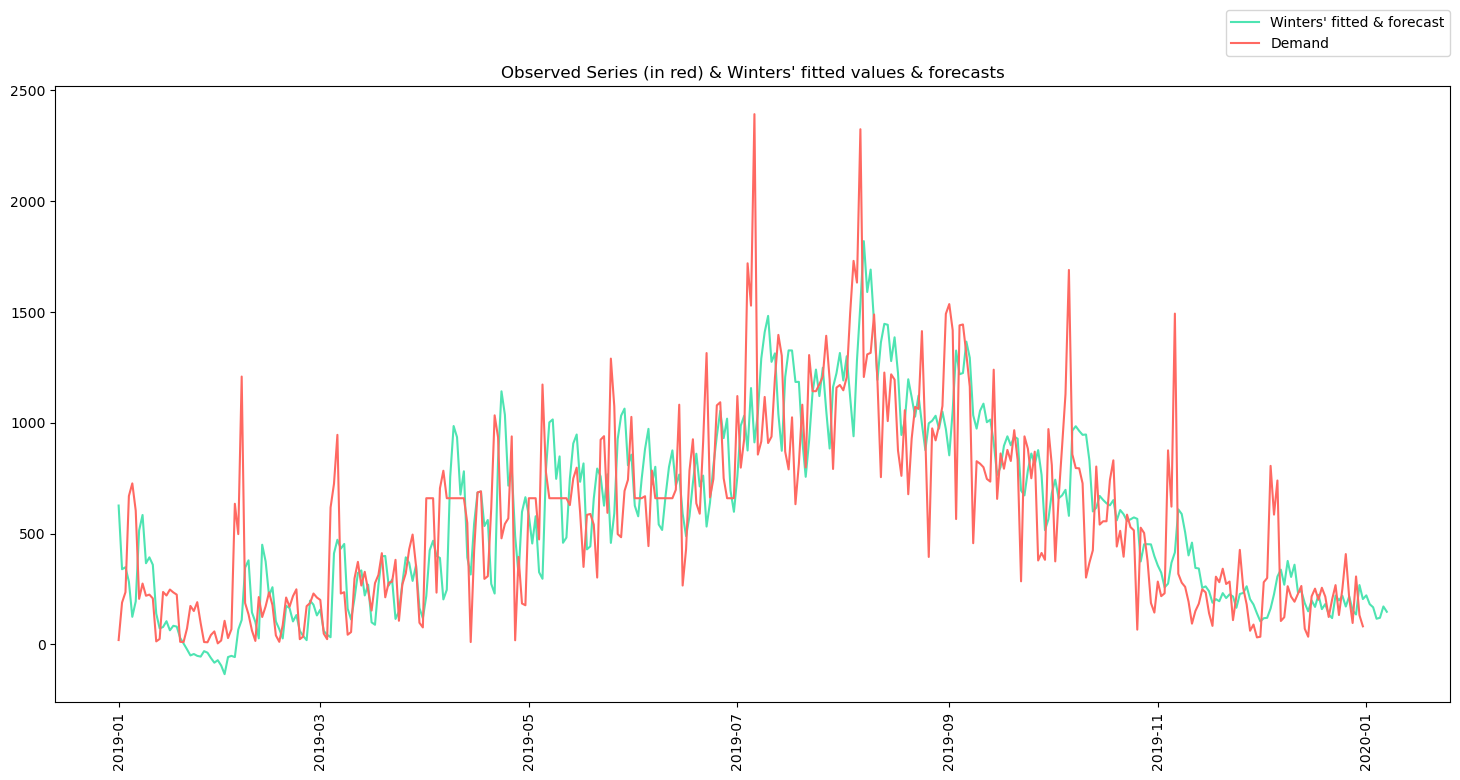


Last 14 observed (in red) & fitted values, & 7 forecasts:


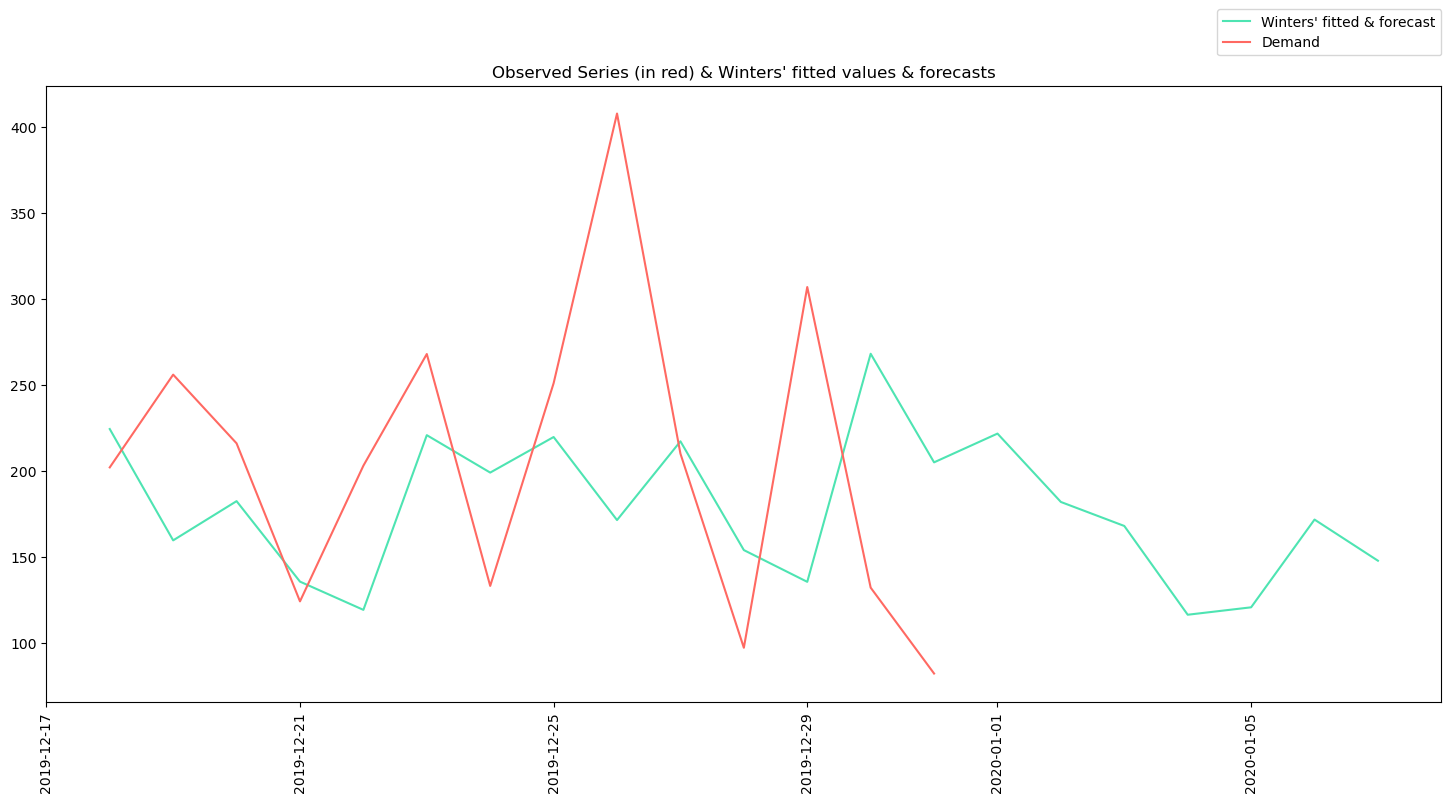

Last observation & 7 Winters' forecasts:

2019-12-31     82.000000
2020-01-01    221.680400
2020-01-02    181.868362
2020-01-03    167.900806
2020-01-04    116.225739
2020-01-05    120.544653
2020-01-06    171.622374
2020-01-07    147.669736
Freq: D, dtype: float64


In [30]:
if 'md' in vars() or 'md' in globals() or 'md' in vars(__builtins__):
    del md #delete md if defined during previous run
    
#Winters':
try:
#     print("\n\nTime series has non-positive value(s), so Winters' trend & seasonal components must be additive.")
    md = ExponentialSmoothing(dt.astype('double'), trend='add', seasonal='mul', freq=freq1, seasonal_periods=period1)
except:
    try:
        md = ExponentialSmoothing(dt.astype('double'), trend='mul', seasonal='add', freq=freq1, seasonal_periods=period1)
    except:
        try:
            #dt must be strictly positive when using multiplicative trend or seasonal component 
            print("\n\nTime series has non-positive value(s), so Winters' trend & seasonal components must be additive.")
            md = ExponentialSmoothing(dt.astype('double'), trend='add', seasonal='add', freq=freq1, seasonal_periods=period1)
        except:
            #necesary for Azure server 2019; changing to default seasonal='add', which means Holt's instead of Winters':
            md = ExponentialSmoothing(dt.astype('double'), trend='add', freq=freq1, seasonal_periods=period1)
            print("To get around a crash, done Holt's instead of Winters'.")
mtd = "Winters'"
mf = md.fit()

print(f"\033[94m\033[1m")

print("\nWinters' Triple Exponential Fit:")
lb = "Winters'"
print(f"\033[0m")

print(mf.summary()) #no output on Azure server; only shows 'None'
#print(np.array(list(mf.params.items())))
prd = mf.forecast(period1) #same as above
print('\nLast', npr, 'observed (in red) & fitted values, &', period1, 'forecasts:')
pl.plot(pd.concat((mf.fittedvalues[-npr:], prd)), label=lb+' fitted & forecast', color='#4EE4B2')
pl.plot(dt[-npr:], color='#FF6962', label=dt.name)
pl.xticks(rotation=90)
pl.legend(bbox_to_anchor=(1.005, 1.135)) #place legend precisely for 18x8 plot to avoid title
pl.title('Observed Series (in red) & '+('Simple Exponential' if i==1 else
                        ("Holt's" if i==2 else "Winters'"))+' fitted values & forecasts')
pl.show()
    
lpr = min(nr, 2 * period1) #last periods
if npr > 1.5 * lpr:
    print('\nLast', lpr, 'observed (in red) & fitted values, &', period1, 'forecasts:')
    pl.plot(pd.concat((mf.fittedvalues[-lpr:], prd)), label=lb+' fitted & forecast', color='#4EE4B2')
    if i == 3:
        fitprd_win = pd.concat((mf.fittedvalues[-lpr:], prd))
    pl.plot(dt[-lpr:], color='#FF6962' , label=dt.name)
    pl.xticks(rotation=90)
    pl.legend(bbox_to_anchor=(1.005, 1.135)) #place legend precisely for 18x8 plot to avoid title
    pl.title('Observed Series (in red) & '+('Simple Exponential' if i==1 else
                        ("Holt's" if i==2 else "Winters'"))+' fitted values & forecasts')
    pl.show()
        
print('Last observation &', period1, ('Simple Exponential' if i==1 else
                                ("Holt's" if i==2 else "Winters'")), 'forecasts:\n')
print(pd.concat([dt[-1:], prd]))
    
if 'mf2' in vars() or 'mf2' in globals() or 'mf2' in vars(__builtins__):
    del mf2 #delete mf2 if defined during previous rundd

In [31]:
mf.fittedvalues

y_m_d
2019-01-01    626.949762
2019-01-02    339.585673
2019-01-03    348.599862
2019-01-04    283.690185
2019-01-05    124.996426
                 ...    
2019-12-27    217.179822
2019-12-28    153.860089
2019-12-29    135.374324
2019-12-30    268.150688
2019-12-31    204.936037
Freq: D, Length: 365, dtype: float64

In [32]:
dt

y_m_d
2019-01-01     20.0
2019-01-02    189.0
2019-01-03    236.0
2019-01-04    670.0
2019-01-05    727.0
              ...  
2019-12-27    210.0
2019-12-28     97.0
2019-12-29    307.0
2019-12-30    132.0
2019-12-31     82.0
Freq: D, Name: Demand, Length: 365, dtype: float64

In [33]:
np.square(mf.fittedvalues.corr(dt))

0.5497959639717671

# Sklearn Predictive Model

In [34]:
from sklearn.preprocessing import StandardScaler

import sklearn.tree as tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 

In [35]:
df_rf = pd.read_csv("top_20_hourly.csv")

In [36]:
df_rf.head()

,y_m_d,hour_of_day,tripduration,Demand,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,tempHigh,tempLow,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptHigh,dewptLow,dewptAvg,windchillHigh,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal,Year_Date,Month_Date,Day_Date,season,is_holiday,break_types,day_of_week,is_weekday
0,2019-01-01,0,102.0,1.0,0.0,0.0,156.0,99.0,97.0,97.0,2.0,2.0,2.0,1.0,0,0.0,2.0,0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1014.22,1012.53,1.02,0.0,0.0,2019,1,1,1,1,3,1,1
1,2019-01-01,1,1158.0,1.0,0.0,0.0,147.0,97.0,95.0,96.0,2.0,2.0,2.0,2.0,0,0.0,4.0,0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1015.92,1013.88,1.70,0.0,0.0,2019,1,1,1,1,3,1,1
2,2019-01-01,2,1028.0,3.0,0.0,0.0,134.0,96.0,93.0,94.0,2.0,1.0,2.0,4.0,0,0.0,7.0,0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1017.27,1015.58,1.36,0.0,0.0,2019,1,1,1,1,3,1,1
3,2019-01-01,3,770.0,1.0,0.0,0.0,141.0,97.0,93.0,94.0,1.0,1.0,1.0,3.0,0,0.0,5.0,0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1018.29,1017.27,1.02,0.0,0.0,2019,1,1,1,1,3,1,1
4,2019-01-01,4,362.0,1.0,0.0,0.0,187.0,99.0,96.0,98.0,1.0,0.0,1.0,7.0,0,1.0,9.0,0,1.0,1.0,0.0,0.0,1.0,-2.0,1.0,1.0,0.0,1.0,1019.30,1018.29,1.02,0.0,0.0,2019,1,1,1,1,3,1,1


In [37]:
df_rf.shape

(8760, 41)

In [38]:
df_rf['y_m_d'] = pd.to_datetime(df_rf['y_m_d'])

In [39]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   y_m_d               8760 non-null   datetime64[ns]
 1   hour_of_day         8760 non-null   int64         
 2   tripduration        8760 non-null   float64       
 3   Demand              8760 non-null   float64       
 4   solarRadiationHigh  8760 non-null   float64       
 5   uvHigh              8760 non-null   float64       
 6   winddirAvg          8760 non-null   float64       
 7   humidityHigh        8760 non-null   float64       
 8   humidityLow         8760 non-null   float64       
 9   humidityAvg         8760 non-null   float64       
 10  tempHigh            8760 non-null   float64       
 11  tempLow             8760 non-null   float64       
 12  tempAvg             8760 non-null   float64       
 13  windspeedHigh       8760 non-null   float64     

In [40]:
df_rf['break_types'] = df_rf["break_types"].apply(int)
df_rf['Month_Date'] = df_rf["Month_Date"].apply(int)

In [41]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   y_m_d               8760 non-null   datetime64[ns]
 1   hour_of_day         8760 non-null   int64         
 2   tripduration        8760 non-null   float64       
 3   Demand              8760 non-null   float64       
 4   solarRadiationHigh  8760 non-null   float64       
 5   uvHigh              8760 non-null   float64       
 6   winddirAvg          8760 non-null   float64       
 7   humidityHigh        8760 non-null   float64       
 8   humidityLow         8760 non-null   float64       
 9   humidityAvg         8760 non-null   float64       
 10  tempHigh            8760 non-null   float64       
 11  tempLow             8760 non-null   float64       
 12  tempAvg             8760 non-null   float64       
 13  windspeedHigh       8760 non-null   float64     

In [42]:
df_rf["season"] = pd.Categorical(df_rf["season"])
season_dummies = pd.get_dummies(df_rf["season"], drop_first=True, prefix="season")
df_rf = pd.concat([df_rf, season_dummies], axis=1)
df_rf.drop(columns=["season"], inplace=True)
df_rf = df_rf.rename(columns={'season_1': 'season_winter', 'season_2': 'season_spring', 'season_3': 'season_summer', 'season_4': 'season_autumn'})

In [43]:
df_rf["break_types"] = pd.Categorical(df_rf["break_types"])
break_types_dummies = pd.get_dummies(df_rf["break_types"], drop_first=True, prefix="break_types")
df_rf = pd.concat([df_rf, break_types_dummies], axis=1)
df_rf.drop(columns=["break_types"], inplace=True)
df_rf = df_rf.rename(columns={'break_types_1': 'break_types_one', 'break_types_2': 'break_types_two', 'break_types_3': 'break_types_three',})

In [44]:
df_rf["Month_Date"] = pd.Categorical(df_rf["Month_Date"])
month_date_dummies = pd.get_dummies(df_rf["Month_Date"], drop_first=True, prefix="month_date")
df_rf = pd.concat([df_rf, month_date_dummies], axis=1)
df_rf.drop(columns=["Month_Date"], inplace=True)

In [45]:
# df_rf["from_station_name"] = pd.Categorical(df_rf["from_station_name"])
# month_date_dummies = pd.get_dummies(df_rf["from_station_name"], drop_first=True, prefix="origin_")
# df_rf = pd.concat([df_rf, month_date_dummies], axis=1)
# df_rf.drop(columns=["from_station_name"], inplace=True)

In [46]:
df_rf.head()

,y_m_d,hour_of_day,tripduration,Demand,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,tempHigh,tempLow,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptHigh,dewptLow,dewptAvg,windchillHigh,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal,Year_Date,Day_Date,is_holiday,day_of_week,is_weekday,season_spring,season_summer,season_autumn,break_types_one,break_types_two,break_types_three,month_date_2,month_date_3,month_date_4,month_date_5,month_date_6,month_date_7,month_date_8,month_date_9,month_date_10,month_date_11,month_date_12
0,2019-01-01,0,102.0,1.0,0.0,0.0,156.0,99.0,97.0,97.0,2.0,2.0,2.0,1.0,0,0.0,2.0,0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1014.22,1012.53,1.02,0.0,0.0,2019,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2019-01-01,1,1158.0,1.0,0.0,0.0,147.0,97.0,95.0,96.0,2.0,2.0,2.0,2.0,0,0.0,4.0,0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1015.92,1013.88,1.70,0.0,0.0,2019,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2019-01-01,2,1028.0,3.0,0.0,0.0,134.0,96.0,93.0,94.0,2.0,1.0,2.0,4.0,0,0.0,7.0,0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1017.27,1015.58,1.36,0.0,0.0,2019,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2019-01-01,3,770.0,1.0,0.0,0.0,141.0,97.0,93.0,94.0,1.0,1.0,1.0,3.0,0,0.0,5.0,0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1018.29,1017.27,1.02,0.0,0.0,2019,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2019-01-01,4,362.0,1.0,0.0,0.0,187.0,99.0,96.0,98.0,1.0,0.0,1.0,7.0,0,1.0,9.0,0,1.0,1.0,0.0,0.0,1.0,-2.0,1.0,1.0,0.0,1.0,1019.30,1018.29,1.02,0.0,0.0,2019,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df_rf.dtypes

y_m_d                 datetime64[ns]
hour_of_day                    int64
tripduration                 float64
Demand                       float64
solarRadiationHigh           float64
uvHigh                       float64
winddirAvg                   float64
humidityHigh                 float64
humidityLow                  float64
humidityAvg                  float64
tempHigh                     float64
tempLow                      float64
tempAvg                      float64
windspeedHigh                float64
windspeedLow                   int64
windspeedAvg                 float64
windgustHigh                 float64
windgustLow                    int64
windgustAvg                  float64
dewptHigh                    float64
dewptLow                     float64
dewptAvg                     float64
windchillHigh                float64
windchillLow                 float64
windchillAvg                 float64
heatindexHigh                float64
heatindexLow                 float64
h

In [48]:
#This function is to address collinearity issue

def delcorr(df):
    corv = df.iloc[:, 1:].corrwith(df[y]).rename(y).sort_values(key=abs).to_frame()
    
    # corr difference lower limit
    delta = 0.01
    dl2 = []
    icorr = True
    while icorr:
        a = abs(corv).diff() <= delta
        col_name=list(df)[1:]
        dl=[]
        print('\nX pairs with correlations >', 1 - delta, ':')
        for b in range(1, a.shape[0]):
            if a.iloc[b, 0]:
                if abs(df[a.index[b-1]].corr(df[a.index[b]])) > 1 - delta:
                    #deleting 1 X from correlated pair:
                    dv0 = a.index[b - 1]
                    dv1 = a.index[b]
                    
                    #neither should already be deleted:
                    if not (dv0 in dl) and not (dv1 in dl):
                        #delete x with rather lower corr(x, y):
                        if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                            d = dv1
                        elif len(dv0) < len(dv1):
                            d = dv1
                        else:
                            d = dv0
                        #for en masse deletion later    
                        dl.append(d)
                        #delete from column of corr with y
                        corv.drop([d], axis=0, inplace=True)
                        print(dv0, ',', dv1)
        
        if len(dl) > 0:
            #variables deleted en masse
            df.drop(axis=1, columns=dl, inplace=True)
            #Keep for real deletion later
            dl2 = dl2 + dl
            print('\n' + str(len(dl)), 'variables considered for deletion:')
            print('\n'.join([str(x) for x in dl]))
        else:
            print('(no more)')
            icorr = False
    print('\n' + str(len(dl2)), 'collinear variables deleted.')
    return dl2

In [49]:
#Defining target variable
y='Demand'

In [50]:
#Create a copy of df_negbin and store it in a variable named df_negbin_copy
df_rf_copy = df_rf.copy()
print(df_rf)
print(df_rf.dtypes)
#find collinearity deletion candidates among original variables.
dl2 = delcorr(df_rf)

print(dl2)

if len(dl2) > 0:
    #collinear transformed variables deleted en masse, for real
    df_rf_copy.drop(axis=1, columns=dl2, inplace=True)
    #remaining Xs may still have multi-X collinearity
    print('\n' + str(len(dl2)), 'variables deleted.')
    
#only numeric columns left

#move transformations more correlated with Y to front:
df_rf_copy = pd.concat([df_rf_copy[list(df_rf_copy)[:num_col]], df_rf_copy[df_rf_copy[[c for c in list(df_rf_copy)[num_col:] if c != y]].corrwith(df_rf_copy[y]
                    ).sort_values(key=abs, ascending=False).index]], 1)

#keep df_negbin_copy for inclusion of interaction variables later
df_rf = df_rf_copy.copy() 

df_rf_copy.head(5)

          y_m_d  hour_of_day  tripduration  Demand  solarRadiationHigh  uvHigh  winddirAvg  humidityHigh  humidityLow  \
0    2019-01-01            0    102.000000     1.0                 0.0     0.0       156.0          99.0         97.0   
1    2019-01-01            1   1158.000000     1.0                 0.0     0.0       147.0          97.0         95.0   
2    2019-01-01            2   1028.000000     3.0                 0.0     0.0       134.0          96.0         93.0   
3    2019-01-01            3    770.000000     1.0                 0.0     0.0       141.0          97.0         93.0   
4    2019-01-01            4    362.000000     1.0                 0.0     0.0       187.0          99.0         96.0   
...         ...          ...           ...     ...                 ...     ...         ...           ...          ...   
8755 2019-12-31           19   1096.000000     7.0                 0.0     0.0       203.0          84.5         82.5   
8756 2019-12-31           20   1

,y_m_d,hour_of_day,tripduration,Demand,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptAvg,pressureMax,season_summer,break_types_one,month_date_8,month_date_7,month_date_2,month_date_12,month_date_3,season_autumn,month_date_11,month_date_9,is_holiday,break_types_two,Day_Date,break_types_three,month_date_6,precipRate,month_date_5,pressureTrend,precipTotal,season_spring,is_weekday,day_of_week,month_date_4,month_date_10,Year_Date
0,2019-01-01,0,102.0,1.0,0.0,0.0,156.0,99.0,97.0,97.0,2.0,1.0,0,0.0,2.0,0,0.0,2.0,1014.22,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.0,0,1.02,0.0,0,1,1,0,0,2019
1,2019-01-01,1,1158.0,1.0,0.0,0.0,147.0,97.0,95.0,96.0,2.0,2.0,0,0.0,4.0,0,0.0,1.0,1015.92,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.0,0,1.70,0.0,0,1,1,0,0,2019
2,2019-01-01,2,1028.0,3.0,0.0,0.0,134.0,96.0,93.0,94.0,2.0,4.0,0,0.0,7.0,0,1.0,1.0,1017.27,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.0,0,1.36,0.0,0,1,1,0,0,2019
3,2019-01-01,3,770.0,1.0,0.0,0.0,141.0,97.0,93.0,94.0,1.0,3.0,0,0.0,5.0,0,1.0,0.0,1018.29,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.0,0,1.02,0.0,0,1,1,0,0,2019
4,2019-01-01,4,362.0,1.0,0.0,0.0,187.0,99.0,96.0,98.0,1.0,7.0,0,1.0,9.0,0,1.0,0.0,1019.30,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.0,0,1.02,0.0,0,1,1,0,0,2019


In [51]:
# split into test/train test
# X = df_rf.drop(columns=['tripduration', 'from_station_name', 'Demand', 'y_m_d', 'humidityHigh','humidityLow','tempHigh','tempLow','windspeedHigh','windspeedLow','windgustHigh',
#                  'windgustLow','dewptHigh','dewptLow','windchillHigh','windchillLow','heatindexHigh',
#                  'heatindexLow','pressureMax','pressureMin', 'Year_Date', 'Day_Date', 'is_holiday'], axis = 1)

X = df_rf.drop(columns=['Demand', 'y_m_d', 'Year_Date', 'Day_Date', 'is_holiday'], axis = 1)

X_train_colname = X.columns.tolist()
y = df_rf.Demand

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# standardize 
ss = StandardScaler()
X_scaled = ss.fit(X_train)
X_train = X_scaled.transform(X_train)
X_test = X_scaled.transform(X_test)

### Decision Tree

In [52]:
#GridSearch DT

# set parameter search range
max_depth_range = list(range(1, 16))
min_samples_leaf_range= list(range(1,8))
alpha_vec = np.linspace(0, 0.1, 10)
param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range, ccp_alpha = alpha_vec)

# fit the model with different parameters
mytree = GridSearchCV(tree.DecisionTreeRegressor(random_state=0), param_grid2, cv=5, scoring='neg_mean_squared_error', return_train_score=False)
mytree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'ccp_alpha': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]},
             scoring='neg_mean_squared_error')

In [53]:
mytree.best_params_

{'ccp_alpha': 0.011111111111111112, 'max_depth': 11, 'min_samples_leaf': 7}

In [54]:
# Same pattern as all SKL 
# Step 1. define the model object
# mytree = tree.DecisionTreeRegressor(random_state = 0)

# Step 2. Call the "fit" function to do the fitting 
# mytree.fit(X_train, y_train)

# Step 3. Report results
tree_mse = mean_squared_error(y_test, mytree.predict(X_test))
tree_r2 = r2_score(y_test, mytree.predict(X_test))
print(f"MSE from tree on test set = {tree_mse}, R^2 = {tree_r2}")

MSE from tree on test set = 316.2451900674375, R^2 = 0.7082822370742639


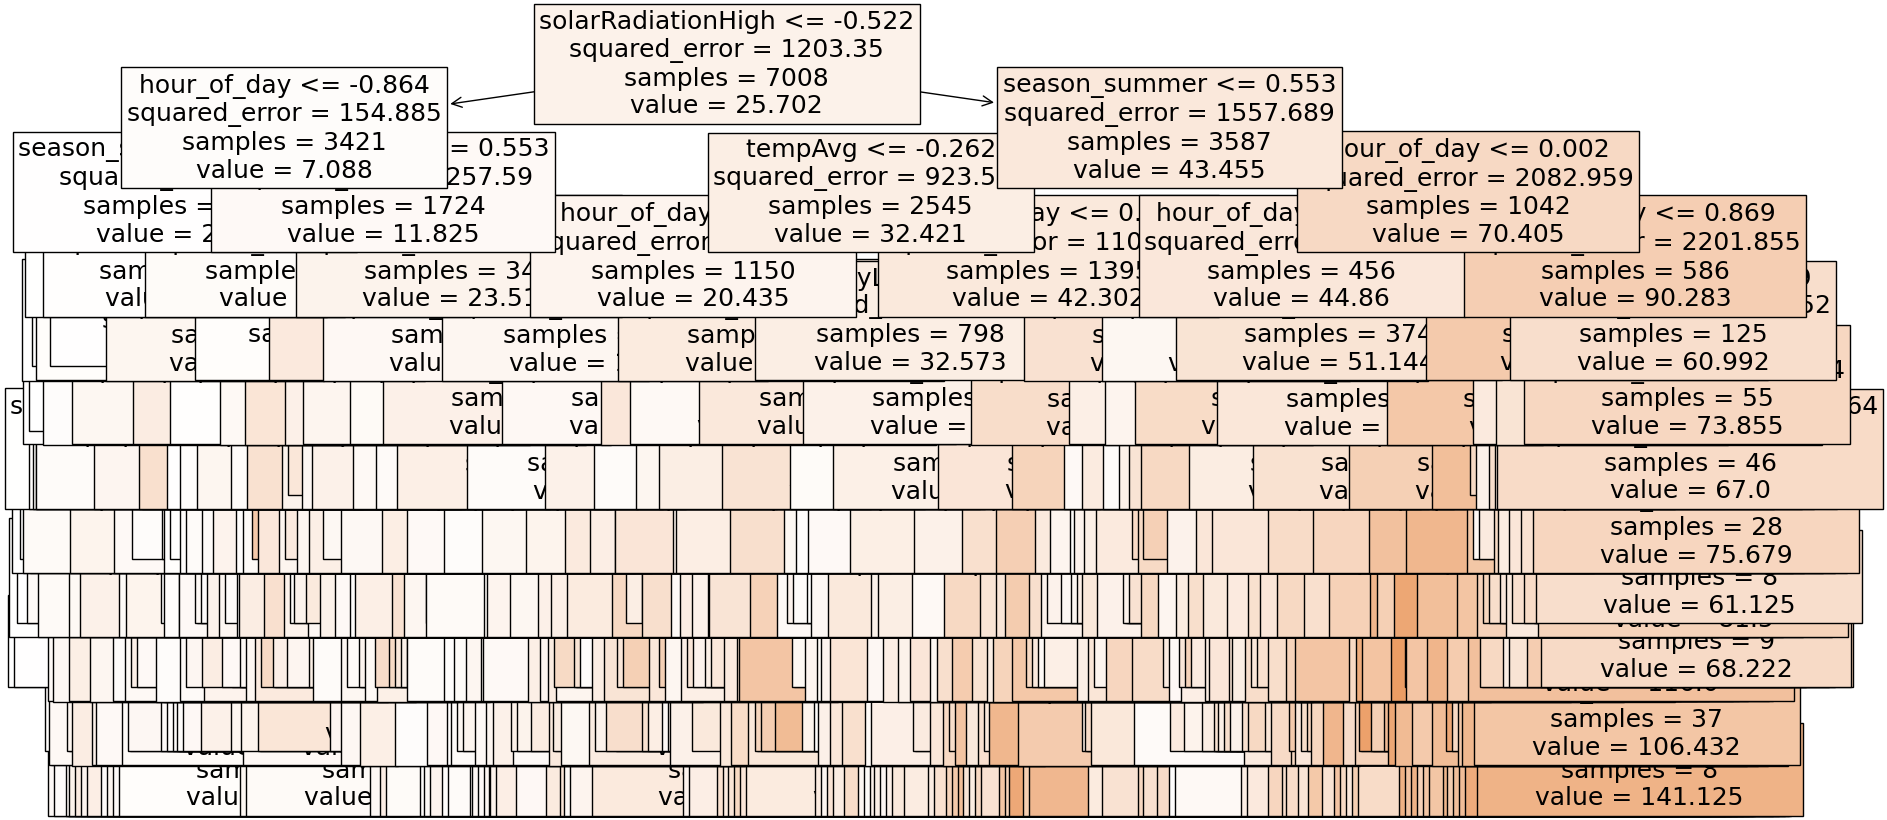

In [55]:
# Visualize
plt.figure(figsize = (20,10))
tree.plot_tree(mytree.best_estimator_, feature_names=X.columns, fontsize = 18, filled = True)
plt.show()

In [56]:
# Without GridSearchCV, limiting the max depth for regularisation purposes

mytree2 = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=1,random_state=0)
mytree2.fit(X_train, y_train)

# Step 3. Report results
tree2_mse = mean_squared_error(y_test, mytree2.predict(X_test))
tree2_r2 = r2_score(y_test, mytree2.predict(X_test))

In [57]:
print(f"MSE from tree on test set = {tree2_mse}, R^2 = {tree2_r2}")

MSE from tree on test set = 477.0643519581715, R^2 = 0.5599359297917639


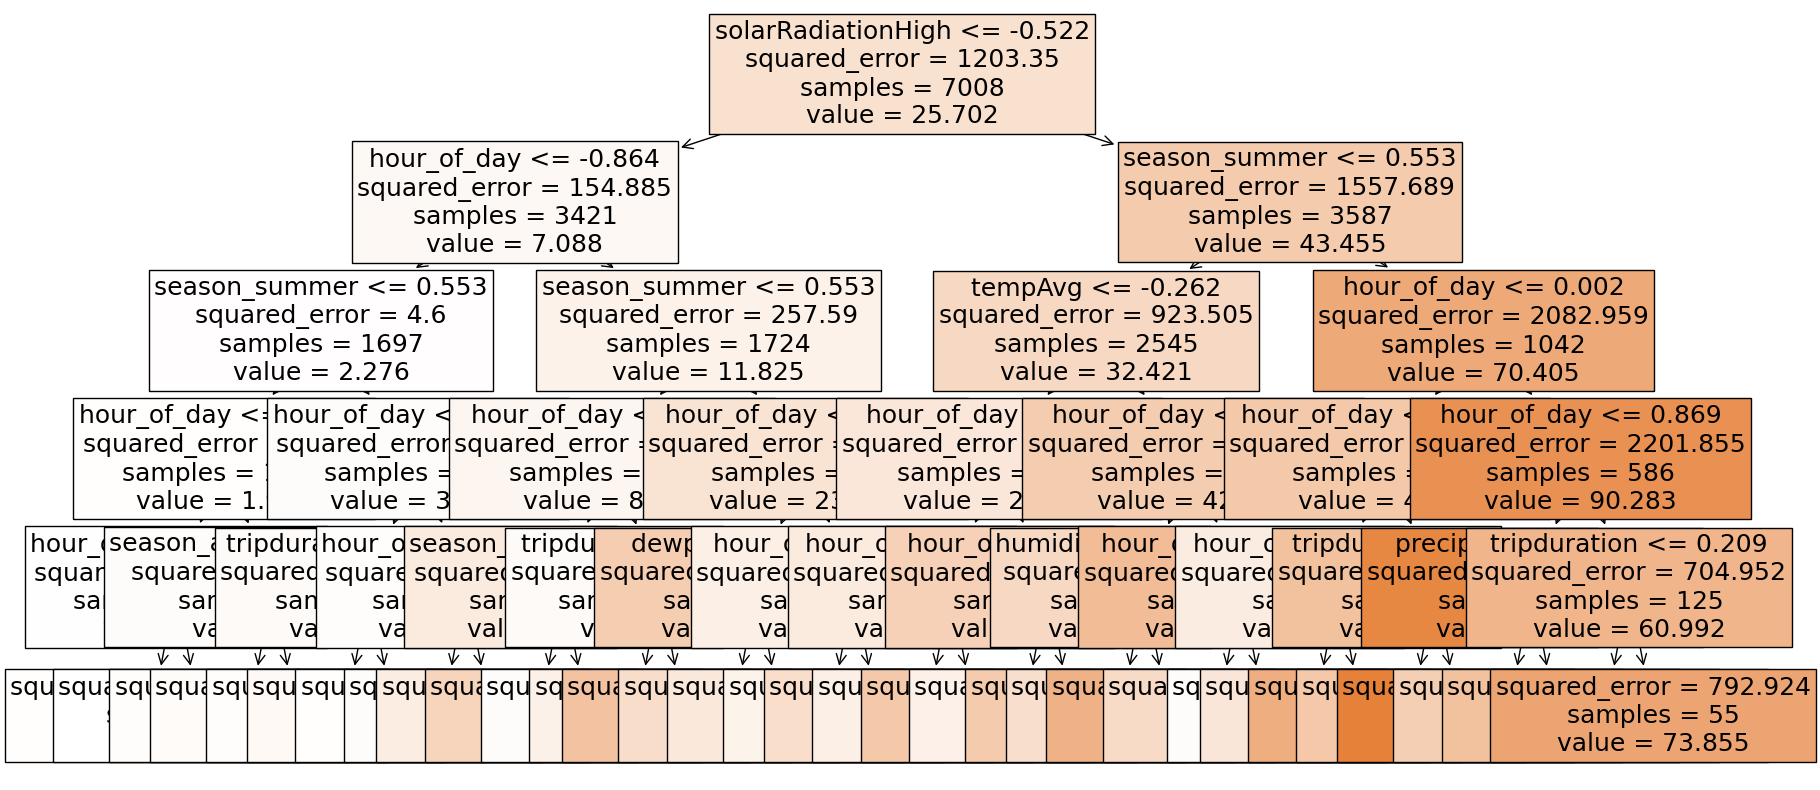

In [58]:
# Visualize
plt.figure(figsize = (20,10))
tree.plot_tree(mytree2, feature_names=X.columns, fontsize = 18, filled = True)
plt.show()

### Random Forest

In [59]:
myforest = RandomForestRegressor(n_estimators=100)

In [60]:
parameter_space = \
    {
        "n_estimators": [10, 100],
        "max_depth": [6, 7, 8, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 5],
        "max_features": ['sqrt'],
        "bootstrap": [True, False],
    }

myforest = GridSearchCV(RandomForestRegressor(random_state=0),
                   parameter_space, cv=5, scoring = "neg_mean_squared_error", n_jobs=4)
myforest.fit(X_train, y_train)


myforest.fit(X_train, y_train)
print("Best parameters:")
print(myforest.best_params_)

Best parameters:
{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [61]:
rf_mse = mean_squared_error(y_test, myforest.predict(X_test))
rf_r2 = r2_score(y_test, myforest.predict(X_test))
print(f"RandomForest Regressor complete. On test set, MSE = {rf_mse}, R^2 = {rf_r2}")

RandomForest Regressor complete. On test set, MSE = 317.76443588646794, R^2 = 0.7068808213197117


In [62]:
#69.5
#54.04
#20.4
#77

In [63]:
sel = SelectFromModel(myforest.best_estimator_)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=False, max_depth=10,
                                                max_features='sqrt',
                                                random_state=0))

In [64]:
sel.get_support()

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [65]:
X_train_dataframe = pd.DataFrame(X_train, columns=X_train_colname)

In [66]:
selected_feat= X_train_dataframe.columns[(sel.get_support())]
len(selected_feat)

10

In [67]:
print(selected_feat)

Index(['hour_of_day', 'tripduration', 'solarRadiationHigh', 'uvHigh', 'humidityHigh', 'humidityLow', 'humidityAvg',
       'tempAvg', 'dewptAvg', 'season_summer'],
      dtype='object')


In [68]:
X_train

array([[ 5.07749160e-01, -1.25965240e-01, -2.46648617e-01, ...,
        -9.98593406e-01, -2.97551361e-01, -3.02917218e-01],
       [ 9.40826296e-01, -4.64143653e-01, -4.85156361e-01, ...,
         2.64310437e-03, -2.97551361e-01, -3.02917218e-01],
       [-6.96870221e-02,  1.33160608e+00,  2.05295247e+00, ...,
        -1.49921166e+00, -2.97551361e-01, -3.02917218e-01],
       ...,
       [-6.96870221e-02,  4.70020250e-01,  2.79535770e+00, ...,
        -1.49921166e+00, -2.97551361e-01, -3.02917218e-01],
       [-1.65763652e+00,  6.09147060e-01, -5.30799756e-01, ...,
         5.03261360e-01, -2.97551361e-01, -3.02917218e-01],
       [ 1.22954439e+00,  4.80148324e-01, -5.30799756e-01, ...,
        -4.97975151e-01,  3.36076432e+00, -3.02917218e-01]])

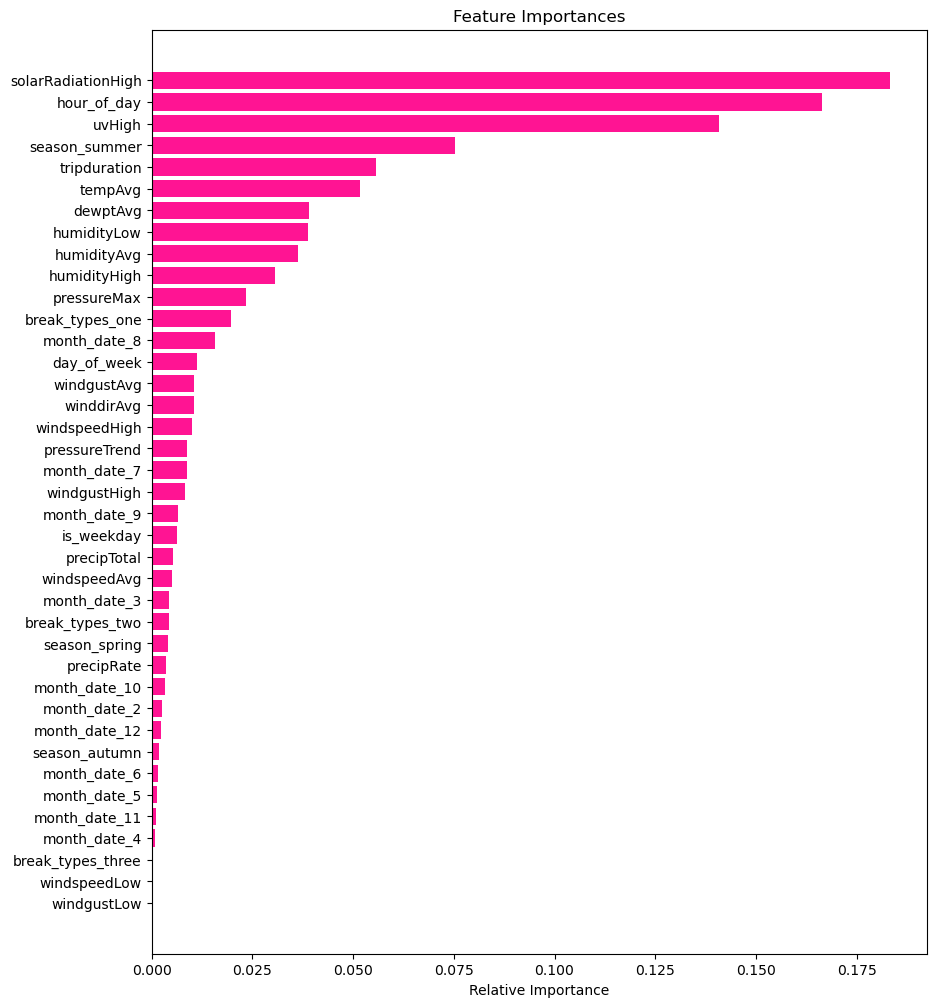

In [69]:
features = X_train_dataframe.columns.tolist()
importances = myforest.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='deeppink', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

### Support Vector Regressor (SVR)

In [70]:
parameter_space = \
    {
        "kernel": ["rbf"],
        "degree": [3, 5],
        "coef0": [0, 3, 7],
        "gamma":[1e-3, 1e-1, 1/X_train.shape[1]],
        "C": [1, 10, 100],
    }

mysvr = GridSearchCV(SVR(), parameter_space, cv=5, n_jobs=4,
                   scoring="neg_mean_squared_error")

mysvr.fit(X_train, y_train)
print("Best parameters:")
print(mysvr.best_params_)

Best parameters:
{'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}


In [71]:
svr_model = SVR(**mysvr.best_params_)

In [72]:
svr_model.fit(X_train, y_train);

In [73]:
y_pred = svr_model.predict(X_test)
svr_mse = mean_squared_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)
print("Support Vector Regression MSE =", svr_mse)
print("Support Vector Regression R^2 =", svr_r2)

Support Vector Regression MSE = 362.9339732151649
Support Vector Regression R^2 = 0.6652145547778929


### Neural Network

In [74]:
from sklearn.neural_network import MLPRegressor

parameter_space = \
    {
        "hidden_layer_sizes": [(7,)*3, (19,), (35,), (55,)],
        "activation": ["relu"],
        "solver": ["lbfgs"],
        "alpha": [1, 10, 100],
    }

mynn = GridSearchCV(MLPRegressor(random_state=3), parameter_space, 
                   cv=3, scoring="neg_mean_squared_error", n_jobs=4)

mynn.fit(X_train, y_train)
print("Best parameters:")
print(mynn.best_params_)

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs fa

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs fa

Best parameters:
{'activation': 'relu', 'alpha': 100, 'hidden_layer_sizes': (55,), 'solver': 'lbfgs'}


In [75]:
nn_model = MLPRegressor(**mynn.best_params_)
nn_model.fit(X_train, y_train);

y_pred = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, y_pred)
nn_r2 = r2_score(y_test, y_pred)

print("Neural Network MSE =", nn_mse)
print("Neural Network R^2 =", nn_r2)

Neural Network MSE = 377.7537794056299
Neural Network R^2 = 0.6515441469909682


### Bagging-Based Emsemble Model

In [76]:
parameter_space = \
    {
        "base_estimator__n_estimators": [10, 100],
        "base_estimator__max_depth": [5, 6, 7],
        "base_estimator__min_samples_split": [2, 5],
        "base_estimator__min_samples_leaf": [1, 5],
        "base_estimator__max_features": ['sqrt'],
        "n_estimators": [10, 20, 40],
    }


mybag = GridSearchCV(BaggingRegressor(RandomForestRegressor(random_state=0), max_features = 0.5, random_state=0),
                   parameter_space, cv=3, scoring = "neg_mean_squared_error", n_jobs=4)
mybag.fit(X_train, y_train)

print("Best parameters:")
print(mybag.best_params_)

Best parameters:
{'base_estimator__max_depth': 7, 'base_estimator__max_features': 'sqrt', 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 100, 'n_estimators': 20}


In [77]:
bag_mse = mean_squared_error(y_test, mybag.predict(X_test))
bag_r2 = r2_score(y_test, mybag.predict(X_test))
print(f"Bagged regression complete. On test set, MSE = {bag_mse}, R^2 = {bag_r2}")

Bagged regression complete. On test set, MSE = 481.15645759763805, R^2 = 0.5561612007514696


### XG Boosting

In [78]:
parameter_space = \
    {
        "max_depth": [4, 5],
        "learning_rate": [0.005, 0.01],
        "n_estimators": [100, 200],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

mygboost = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_squared_error", random_state=3)

mygboost.fit(X_train, y_train)
print("Best parameters:")
print(mygboost.best_params_)

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in

Best parameters:
{'subsample': 0.3, 'reg_lambda': 3, 'reg_alpha': 33, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'booster': 'gbtree'}


In [79]:
xgb_model = XGBRegressor(**mygboost.best_params_)
xgb_model.fit(X_train, y_train);
y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

print("XGBoost MSE =", xgb_mse)
print("XGBoost R^2 =", xgb_r2)

XGBoost MSE = 411.6582674231592
XGBoost R^2 = 0.620269232120304


### AdaBoost

In [80]:
parameter_space = \
    {
        "learning_rate": [0.005, 0.01],
        "n_estimators": [100, 200],
    }

myada = RandomizedSearchCV(AdaBoostRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_squared_error", 
                         random_state=3, n_iter=10)

myada.fit(X_train, y_train)
print("Best parameters:")
print(myada.best_params_)

Best parameters:
{'n_estimators': 200, 'learning_rate': 0.01}


In [81]:
ada_model = AdaBoostRegressor(**myada.best_params_)
ada_model.fit(X_train, y_train);
y_pred = ada_model.predict(X_test)
ada_mse = mean_squared_error(y_test, y_pred)
ada_r2 = r2_score(y_test, y_pred)

print("AdaBoost MSE =", ada_mse)
print("AdaBoost R^2 =", ada_r2)

AdaBoost MSE = 541.904260541916
AdaBoost R^2 = 0.5001248917920218


### Voting Regressor

In [82]:
mytree1  = tree.DecisionTreeRegressor(ccp_alpha= 0.011111111111111112, max_depth= 11, min_samples_leaf= 7, random_state=0)
myforest1 = RandomForestRegressor(bootstrap= False, max_depth= 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=0)
mysvr1   = SVR(C= 100, coef0= 0, degree= 3,gamma= 0.1, kernel= 'rbf')
mynn1   = MLPRegressor(activation= 'relu', alpha= 100, hidden_layer_sizes= (55,), solver= 'lbfgs', random_state=3)
mybag1 = BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0), n_estimators= 20, random_state=0)
mygboost1 = XGBRegressor(subsample= 0.3, reg_lambda= 3, reg_alpha= 33, n_estimators= 200, max_depth= 4, learning_rate= 0.01, gamma= 100, colsample_bytree= 0.7, colsample_bylevel= 0.7, booster= 'gbtree', random_state=3)
myada1 = AdaBoostRegressor(n_estimators= 200, learning_rate= 0.01, random_state=3)


In [83]:
list_models=[mytree1, myforest1, mysvr1, mynn1, mybag1, mygboost1, myada1]

er1 = VotingRegressor([('mytree', mytree1), ('myforest', myforest1), ('svr_model', mysvr1), ('nn_model', mynn1), ('mybag', mybag1), ('mygboost', mygboost1), ('myada', myada1)])
print(er1.fit(X_train, y_train).predict(X_test))


[ 3.52026343  3.16631133 22.52671324 ...  4.79634696  6.21079515
  2.80886668]


In [84]:
y_pred = er1.predict(X_test)
er_mse1 = mean_squared_error(y_test, y_pred)
er_r21 = r2_score(y_test, y_pred)

In [85]:
print("Best parameters:")
print(er1)

Best parameters:
VotingRegressor(estimators=[('mytree',
                             DecisionTreeRegressor(ccp_alpha=0.011111111111111112,
                                                   max_depth=11,
                                                   min_samples_leaf=7,
                                                   random_state=0)),
                            ('myforest',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=10,
                                                   max_features='sqrt',
                                                   random_state=0)),
                            ('svr_model', SVR(C=100, coef0=0, gamma=0.1)),
                            ('nn_model',
                             MLPRegressor(alpha=100, hidden_layer_sizes=(55,),
                                          random_...
                                          max_delta_step=None, max_depth=4,
                 

In [86]:
xaxis = ['Decision Tree', 'Random Forest', 'SVR', 'RF Bagging', 'Neural Network', 'XGBoost', 'AdaBoost' ,'Voting Regressor']
yaxis = [tree_mse, rf_mse, svr_mse, bag_mse, nn_mse, xgb_mse, ada_mse, er_mse1]
models = pd.DataFrame({
    'Model': xaxis,
    'MSE': yaxis,
    'r^2': [tree_r2, rf_r2, svr_r2, nn_r2, bag_r2, xgb_r2, ada_r2, er_r21]})
models.sort_values(by='r^2', ascending=False)

,Model,MSE,r^2
7,Voting Regressor,284.960764,0.737140
0,Decision Tree,316.245190,0.708282
1,Random Forest,317.764436,0.706881
2,SVR,362.933973,0.665215
3,RF Bagging,481.156458,0.651544
5,XGBoost,411.658267,0.620269
4,Neural Network,377.753779,0.556161
6,AdaBoost,541.904261,0.500125


In [87]:
models.sort_values(by='r^2', ascending=False).reset_index().drop(columns="index")

,Model,MSE,r^2
0,Voting Regressor,284.960764,0.737140
1,Decision Tree,316.245190,0.708282
2,Random Forest,317.764436,0.706881
3,SVR,362.933973,0.665215
4,RF Bagging,481.156458,0.651544
5,XGBoost,411.658267,0.620269
6,Neural Network,377.753779,0.556161
7,AdaBoost,541.904261,0.500125


In [88]:
end = time.time()

In [89]:
print("Time to complete: ", end-start)

Time to complete:  477.84650015830994
